In [ ]:
# This notebook highlight analyses explore the relationship between UFO sightings, military bases, and population.
# The analyses rely on the buildt-in packages listed below and requires an installation of the plotly package.

!pip install plotly

In [1]:
# import packages & adjust jupyter notebook display setting
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell as ip
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
ip.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = [12, 8]

# Extract UFO Data
- Data from the NATIONAL UFO REPORTING CENTER - http://www.nuforc.org
- Access Date: 04/14/2021
- Data Format: Self-reported survey data
- Retreive data only from 2000 to 2021 because there is not much data collected before 2000. The lack of proper technology and internet most likely contributes to the difficulty of collecting data before 2000.

In [2]:
# Define the data time period 
year_start = 2000
year_end = 2020

# Pull data from NUFORC
df = [pd.read_html(f"http://www.nuforc.org/webreports/ndxe{i}{'0' + str(j) if j < 10 else str(j)}.html")[0]
         for i in range(year_start, year_end + 1) for j in range(1, 13)]

# Combine the list of dataframes pulled above into a single pandas dataframe
ufo_raw = pd.concat(df, axis=0).reset_index(drop=True)

# Basic Clean Up For Data Mapping and Summary Statistics of the UFO Dataset - Date and State Variables
- **Data Issue 1**: Event date/time variable missing time in multiple occasions
- **Issue 1 Solution**: Split date/time column, format date and time separately for mapping to supplemental datesets and for analysis. When an analysis relies upon such data, we treat them as a distinct category. We have complete record of date and is used to as mapping to the supplemental datasets.
<br><br>
- **Data Issue 2**: Reporting from outside of the US or with no state data collected
- **Issue 2 Solution**: For the purpose of this report, we only want to focus on the events observed in the US. We are aware that 1) a few events observed in the US are also reported to have no state information due to reporting error and 2) a larger proportion of the observations that do not have a state reporting occurs before 2008 compared to those that have state reporting. However, given the small observation size of such data and the importance of having a reliable data mapping, we decide to drop observations that do not have a state reporting. These dropped observations are also saved for future reference/review.

In [3]:
# Format column names for easy data outputting and wrangling
ufo = ufo_raw
ufo.columns = ufo.columns\
    .str.replace("/", "")\
    .str.replace(" ", "")\
    .str.lower()

# Snippet of the data
print("-"*72 + "\n" + "Below is a snippet of the raw UFO data")
ufo.head(20)

# Num of rows and columns
print("-"*72 + "\n" + f"Num of obs is: {ufo.shape[0]}; Num of variables is {ufo.shape[1]}")

------------------------------------------------------------------------
Below is a snippet of the raw UFO data


datetime                                     city state      shape  \
0   1/31/00 21:00                           Cape Canaveral    FL      Light   
1   1/19/00 03:00                          West Palm Beach    FL        Egg   
2   1/18/00 00:24                    Flamingo (Costa Rica)   NaN   Changing   
3   1/17/00 21:40                                   Orland    CA   Triangle   
4   1/15/00 22:30                               West Fargo    ND     Sphere   
5   1/15/00 20:00                             Lake Charles    LA      Light   
6   1/13/00 23:30  Motherwell (near Glasgow) (UK/Scotland)   NaN     Sphere   
7   1/10/00 22:00                              Erie (area)    PA    Unknown   
8          1/7/00                                   Phelps    WI        NaN   
9    1/5/00 04:30             St. Louis (MO)/Columbia (IL)    MO    Unknown   
10         1/5/00                                  Spokane    WA        NaN   
11   1/4/00 20:30                               Scottsdale    AZ      Light   
12   1/4/00 03:15                                    Union    MO   Triangle   
13   1/2/00 00:00                             Jacksonville    FL  Rectangle   
14   1/2/00 00:30                                     Mesa    AZ       Oval   
15   1/1/00 23:00                                    Erath    LA        Egg   
16   1/1/00 21:00                                   Patoka    IL   Triangle   
17   1/1/00 17:00                                 Rockford    IL    Diamond   
18   1/1/00 05:00                                   Clovis    CA      Light   
19   1/1/00 01:00                                    Omaha    NE      Light   

              duration                                            summary  \
0             1 minute  Glowing green light came up right side of movi...   
1           20 minutes                     Grey visitation and abduction.   
2             1 minute  Out of the corner of my eye a glowing bright, ...   
3           10 minutes  Small triangular object flying low to ground f...   
4           15 minutes  Bright glowing red orb. Did not emit any smoke...   
5           40 minutes  There was a UFO in Lake Charles, Louisiana in ...   
6            2 minutes  While doing some amateur astronomy, I observed...   
7   less than a minute  dark object with strobe/beacon.stationary over...   
8           10 minutes  I have been visited since 1974, I had a missin...   
9           10 seconds                  January 5th, 2000, 5 Dupo lights.   
10               1min.  i saw three beings about 4ft tall looking into...   
11          10 seconds       Emerging, pivoting array of lighted objects.   
12              1 hour  Trangluar Craft over Union, MO Jan. 5th 2000. ...   
13                2hrs  A rectangle shape object like a cigar box (may...   
14              5 min.                         golden orb's flying about.   
15                2:00      Yellow egg shape craft displays of technolegy   
16           5 minutes  Triangular shaped object flying very low to th...   
17           5 minutes       Diamond Shape taking samples from Rock River   
18               1 min          It's a plane, it's a star, NO it's a UFO!   
19          11 minutes  The flying object was moving back & forth in t...   

      posted  
0    10/8/07  
1    12/1/19  
2    1/26/15  
3    6/12/07  
4   10/30/06  
5    1/10/09  
6   12/17/11  
7    12/7/06  
8    1/12/18  
9     3/4/08  
10   2/14/10  
11    7/6/10  
12  10/30/12  
13   1/10/09  
14   1/10/09  
15   5/15/06  
16   6/12/08  
17    6/7/19  
18   2/24/07  
19    4/9/20

------------------------------------------------------------------------
Num of obs is: 90335; Num of variables is 7


------------------------------------------------------------------------
Below is a snippet of the modified UFO data


datetime                                     city state      shape  \
0   1/31/00 21:00                           Cape Canaveral    FL      Light   
1   1/19/00 03:00                          West Palm Beach    FL        Egg   
2   1/18/00 00:24                    Flamingo (Costa Rica)   NaN   Changing   
3   1/17/00 21:40                                   Orland    CA   Triangle   
4   1/15/00 22:30                               West Fargo    ND     Sphere   
5   1/15/00 20:00                             Lake Charles    LA      Light   
6   1/13/00 23:30  Motherwell (near Glasgow) (UK/Scotland)   NaN     Sphere   
7   1/10/00 22:00                              Erie (area)    PA    Unknown   
8          1/7/00                                   Phelps    WI        NaN   
9    1/5/00 04:30             St. Louis (MO)/Columbia (IL)    MO    Unknown   
10         1/5/00                                  Spokane    WA        NaN   
11   1/4/00 20:30                               Scottsdale    AZ      Light   
12   1/4/00 03:15                                    Union    MO   Triangle   
13   1/2/00 00:00                             Jacksonville    FL  Rectangle   
14   1/2/00 00:30                                     Mesa    AZ       Oval   
15   1/1/00 23:00                                    Erath    LA        Egg   
16   1/1/00 21:00                                   Patoka    IL   Triangle   
17   1/1/00 17:00                                 Rockford    IL    Diamond   
18   1/1/00 05:00                                   Clovis    CA      Light   
19   1/1/00 01:00                                    Omaha    NE      Light   

              duration                                            summary  \
0             1 minute  Glowing green light came up right side of movi...   
1           20 minutes                     Grey visitation and abduction.   
2             1 minute  Out of the corner of my eye a glowing bright, ...   
3           10 minutes  Small triangular object flying low to ground f...   
4           15 minutes  Bright glowing red orb. Did not emit any smoke...   
5           40 minutes  There was a UFO in Lake Charles, Louisiana in ...   
6            2 minutes  While doing some amateur astronomy, I observed...   
7   less than a minute  dark object with strobe/beacon.stationary over...   
8           10 minutes  I have been visited since 1974, I had a missin...   
9           10 seconds                  January 5th, 2000, 5 Dupo lights.   
10               1min.  i saw three beings about 4ft tall looking into...   
11          10 seconds       Emerging, pivoting array of lighted objects.   
12              1 hour  Trangluar Craft over Union, MO Jan. 5th 2000. ...   
13                2hrs  A rectangle shape object like a cigar box (may...   
14              5 min.                         golden orb's flying about.   
15                2:00      Yellow egg shape craft displays of technolegy   
16           5 minutes  Triangular shaped object flying very low to th...   
17           5 minutes       Diamond Shape taking samples from Rock River   
18               1 min          It's a plane, it's a star, NO it's a UFO!   
19          11 minutes  The flying object was moving back & forth in t...   

       posted       date   time  
0  2007-10-08 2000-01-31  21:00  
1  2019-12-01 2000-01-19  03:00  
2  2015-01-26 2000-01-18  00:24  
3  2007-06-12 2000-01-17  21:40  
4  2006-10-30 2000-01-15  22:30  
5  2009-01-10 2000-01-15  20:00  
6  2011-12-17 2000-01-13  23:30  
7  2006-12-07 2000-01-10  22:00  
8  2018-01-12 2000-01-07   None  
9  2008-03-04 2000-01-05  04:30  
10 2010-02-14 2000-01-05   None  
11 2010-07-06 2000-01-04  20:30  
12 2012-10-30 2000-01-04  03:15  
13 2009-01-10 2000-01-02  00:00  
14 2009-01-10 2000-01-02  00:30  
15 2006-05-15 2000-01-01  23:00  
16 2008-06-12 2000-01-01  21:00  
17 2019-06-07 2000-01-01  17:00  
18 2007-02-24 2000-01-01  05:00  
19 2020-04-09 2000-01-01  01:00

------------------------------------------------------------------------
Below is a description of the UFO data


datetime     city  state  shape   duration         summary  \
count           90335    90130  85417  87153      86463           90300   
unique          75879    19051     68     22       7786           88430   
top     11/7/15 18:00  Phoenix     CA  Light  5 minutes  MADAR Node 142   
freq              104      442   9574  19480       6413              48   
first             NaN      NaN    NaN    NaN        NaN             NaN   
last              NaN      NaN    NaN    NaN        NaN             NaN   

                     posted                 date   time  
count                 90334                90335  89441  
unique                  416                 6364   1436  
top     2020-06-25 00:00:00  2015-11-07 00:00:00  22:00  
freq                   1770                  290   4788  
first   2006-05-15 00:00:00  2000-01-01 00:00:00    NaN  
last    2021-03-31 00:00:00  2020-12-31 00:00:00    NaN

<AxesSubplot:xlabel='year'>

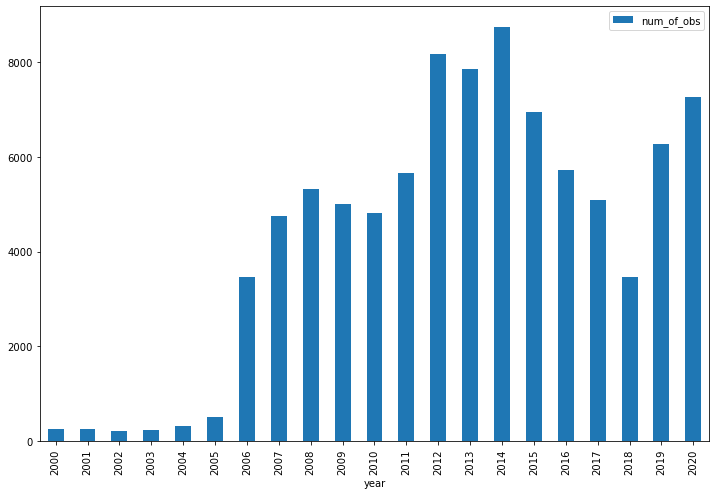

In [4]:
# Data Issue 1
## Split Date/Time
ufo_datetime = ufo.datetime.str.split(pat=" ", expand=True)
ufo_datetime.columns = ["date", "time"]
ufo = pd.concat([ufo, ufo_datetime], axis=1)

## Convert Date from str to date type
ufo["date"] = pd.to_datetime(ufo.date, format="%m/%d/%y")
ufo["posted"] = pd.to_datetime(ufo.posted, format="%m/%d/%y")

# Snippet of the data
print("-"*72 + "\n" + "Below is a snippet of the modified UFO data")
ufo.head(20)

# Summary statistics of the data
print("-"*72 + "\n" + "Below is a description of the UFO data")
ufo.describe()

# Frequency Graph
ufo.assign(year = ufo.date.dt.year)\
    .groupby("year", as_index=False)\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .plot.bar(x="year", y="num_of_obs")

In [5]:
# Data Issue 2
print("-"*72 + "\n" + "Below is the number of observations with no state reporting.")
ufo.date[ufo.state.isnull()].count()

print("-"*72 + "\n" + "Below is a snippet of the null state reporting.")
ufo[ufo.state.isnull()].tail(20)

------------------------------------------------------------------------
Below is the number of observations with no state reporting.


4918

------------------------------------------------------------------------
Below is a snippet of the null state reporting.


datetime                          city state      shape  \
89453   10/1/20 06:00                   Temple City   NaN   Changing   
89507  11/26/20 21:00                        London   NaN        NaN   
89572  11/23/20 17:00                       Norwich   NaN      Cigar   
89602  11/20/20 22:00                     Pikeville   NaN  Formation   
89626  11/19/20 10:00                 San Sebastián   NaN     Circle   
89634  11/19/20 01:20                        Seguin   NaN        NaN   
89684  11/16/20 03:30              Hillsborough, NJ   NaN     Circle   
89780  11/11/20 11:11                  Planet Earth   NaN      Other   
89854   11/6/20 15:20                          Brno   NaN   Changing   
89878   11/5/20 05:45              Charlotte Amalie   NaN      Light   
89936  12/31/20 23:30                  Port St John   NaN        NaN   
90012  12/24/20 23:25           Hoorn (Netherlands)   NaN    Unknown   
90046  12/21/20 01:00                     Los Banos   NaN      Light   
90050  12/20/20 17:25                    Maidenhead   NaN     Sphere   
90071  12/17/20 21:15                       Guayama   NaN   Triangle   
90114  12/13/20 01:30                     Tramandaí   NaN      Light   
90186   12/7/20 17:56                    North Java   NaN      Light   
90266   12/4/20 16:00  Municipal of Puerto Morelos,   NaN     Sphere   
90267   12/4/20 16:00  Municipal of Puerto Morelos,   NaN     Sphere   
90300   12/2/20 19:00                        mexico   NaN     Sphere   

                        duration  \
89453                  2 minutes   
89507                   1 second   
89572                 10 seconfs   
89602  All night every night sin   
89626                Still there   
89634                 10 minutes   
89684                     3 mins   
89780                    Forever   
89854                  2 minutes   
89878                   1 minute   
89936                  5 minutes   
90012         About five minutes   
90046                        NaN   
90050                2-3 minutes   
90071                 10 seconds   
90114                 30 seconds   
90186               6 to 10 min.   
90266                 20 seconds   
90267                 20 seconds   
90300                 still live   

                                                 summary     posted  \
89453  Object approached from south at 400 feet in al... 2020-11-05   
89507  I was looking at the stars as I smoked a cigar... 2020-12-23   
89572  At 17:00 North in the sky over Norwich UK i wi... 2020-12-23   
89602  I’ve been watching multiple UFO every night si... 2020-12-23   
89626  We been seeing a very strange object in the ni... 2020-12-23   
89634    Small bright ballon with unexplained movements. 2020-12-23   
89684  3 people woke up to a loud noise at 3:30AM. We... 2020-12-23   
89780                                    It's a bit sad. 2020-12-23   
89854           White shape changing object near airport 2020-12-23   
89878          Eleven stars moving and then disappearing 2020-12-23   
89936  Orange Fireball the size of a football glided ... 2021-01-19   
90012  Blinking lights, erratic movement, very far away. 2021-01-19   
90046                        My name is ((name deleted)) 2020-12-23   
90050  Line formation of stars moving west-east in th... 2020-12-23   
90071  Standing out in front of the house just after ... 2020-12-23   
90114  Red light turning into white, flying high up i... 2020-12-23   
90186  Took dog out. Large bright white light directl... 2020-12-23   
90266  saw 2 translucent/white objects moving quickly... 2020-12-23   
90267  saw 2 translucent/white objects moving quickly... 2020-12-23   
90300  is still live on webcams de mexico or quantum ... 2020-12-23   

            date   time  
89453 2020-10-01  06:00  
89507 2020-11-26  21:00  
89572 2020-11-23  17:00  
89602 2020-11-20  22:00  
89626 2020-11-19  10:00  
89634 2020-11-19  01:20  
89684 2020-11-16  03:30  
89780 2020-11-11  11:11  
89854 2020-11-06 

datetime                 city state  shape   duration  \
count            4918                 4823     0   4659       4638   
unique           4817                 3127     0     21       1211   
top     9/21/12 23:00  London (UK/England)   NaN  Light  5 minutes   
freq                8                  117   NaN    977        261   
first             NaN                  NaN   NaN    NaN        NaN   
last              NaN                  NaN   NaN    NaN        NaN   

                                                  summary  \
count                                                4918   
unique                                               4902   
top     ((NUFORC Note: Witness provides no information...   
freq                                                    4   
first                                                 NaN   
last                                                  NaN   

                     posted                 date   time  
count                  4918                 4918   4759  
unique                  391                 3040    743  
top     2006-10-30 00:00:00  2009-01-01 00:00:00  22:00  
freq                    163                   16    199  
first   2006-05-15 00:00:00  2000-01-13 00:00:00    NaN  
last    2021-03-02 00:00:00  2020-12-31 00:00:00    NaN

datetime     city  state  shape   duration         summary  \
count           85417    85307  85417  82494      81825           85382   
unique          71843    16166     68     22       7325           83551   
top     11/7/15 18:00  Phoenix     CA  Light  5 minutes  MADAR Node 142   
freq              104      442   9574  18503       6152              48   
first             NaN      NaN    NaN    NaN        NaN             NaN   
last              NaN      NaN    NaN    NaN        NaN             NaN   

                     posted                 date   time  
count                 85416                85417  84682  
unique                  416                 6286   1435  
top     2020-06-25 00:00:00  2015-11-07 00:00:00  22:00  
freq                   1711                  290   4589  
first   2006-05-15 00:00:00  2000-01-01 00:00:00    NaN  
last    2021-03-31 00:00:00  2020-12-31 00:00:00    NaN

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='state'>

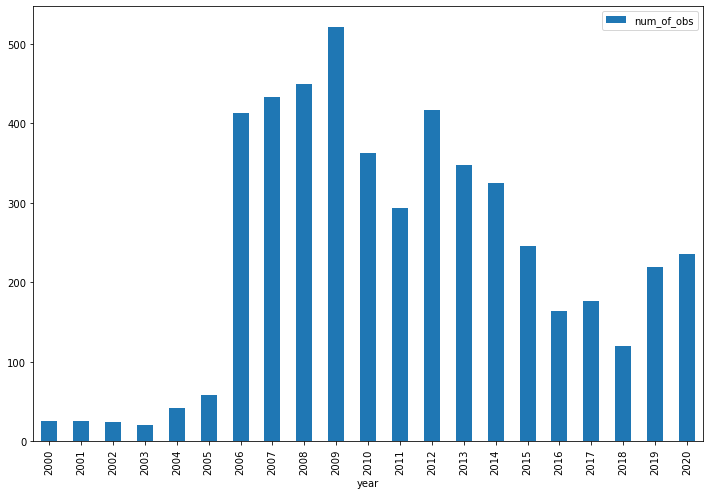

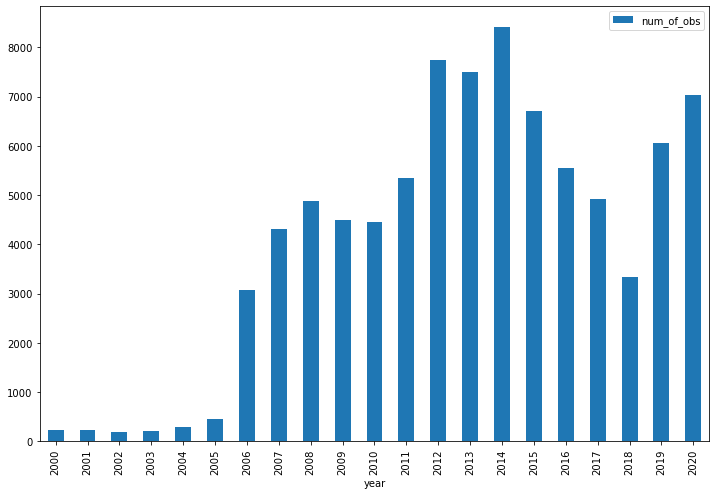

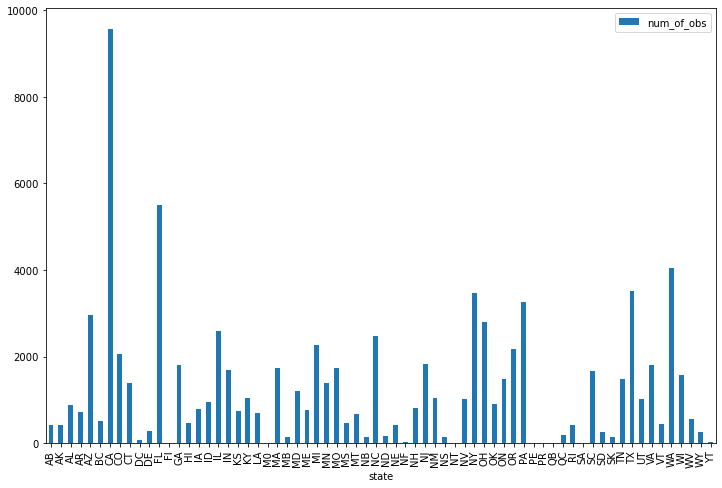

In [6]:
# Check for reason/abnormality in data with reporting error - issue 2
ufo[ufo.state.isnull()].describe()
ufo[ufo.state.notnull()].describe()

ufo[ufo.state.isnull()]\
    .assign(year = ufo.date.dt.year)\
    .groupby("year", as_index=False)\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .plot.bar(x="year", y="num_of_obs")

ufo[ufo.state.notnull()]\
    .assign(year = ufo.date.dt.year)\
    .groupby("year", as_index=False)\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .plot.bar(x="year", y="num_of_obs")

ufo[ufo.state.notnull()]\
    .groupby("state", as_index=False)\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .plot.bar(x="state", y="num_of_obs")


# Process UFO Data

In [7]:
# Importing UFO data for analysis adding year column
ufo["Year"] = [int(str(s)[0:4]) for s in ufo["date"]]
ufo

datetime                   city state     shape     duration  \
0      1/31/00 21:00         Cape Canaveral    FL     Light     1 minute   
1      1/19/00 03:00        West Palm Beach    FL       Egg   20 minutes   
2      1/18/00 00:24  Flamingo (Costa Rica)   NaN  Changing     1 minute   
3      1/17/00 21:40                 Orland    CA  Triangle   10 minutes   
4      1/15/00 22:30             West Fargo    ND    Sphere   15 minutes   
...              ...                    ...   ...       ...          ...   
90330  12/1/20 14:45                Weidman    MI     Light  4-5 minutes   
90331  12/1/20 12:00              Millstone    NJ    Circle       5 mins   
90332  12/1/20 09:00      Barnegat Township    NJ   Unknown       30 min   
90333  12/1/20 06:00              Hyde Park    VT   Diamond       30 sec   
90334  12/1/20 05:09              Jonesboro    AR       NaN          NaN   

                                                 summary     posted  \
0      Glowing green light came up right side of movi... 2007-10-08   
1                         Grey visitation and abduction. 2019-12-01   
2      Out of the corner of my eye a glowing bright, ... 2015-01-26   
3      Small triangular object flying low to ground f... 2007-06-12   
4      Bright glowing red orb. Did not emit any smoke... 2006-10-30   
...                                                  ...        ...   
90330  Extremely bright mirror like light that left v... 2020-12-23   
90331  It flew across highway dropped to the ground a... 2020-12-23   
90332  Witnessed object being chased by fighter jets ... 2020-12-23   
90333  I saw a very bright light in the sky and then ... 2020-12-23   
90334                                     MADAR Node 143 2020-12-23   

            date   time  Year  
0     2000-01-31  21:00  2000  
1     2000-01-19  03:00  2000  
2     2000-01-18  00:24  2000  
3     2000-01-17  21:40  2000  
4     2000-01-15  22:30  2000  
...          ...    ...   ...  
90330 2020-12-01  14:45  2020  
90331 2020-12-01  12:00  2020  
90332 2020-12-01  09:00  2020  
90333 2020-12-01  06:00  2020  
90334 2020-12-01  05:09  2020  

[90335 rows x 10 columns]

In [8]:
# Create state abbreviations mapping for data merging

states = {"AK": "Alaska", "AL": "Alabama", "AR": "Arkansas", "AS": "American Samoa", "AZ": "Arizona",
          "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DC": "District of Columbia",
          "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "GU": "Guam", "HI": "Hawaii",
          "IA": "Iowa", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "KS": "Kansas", 
          "KY": "Kentucky", "LA": "Louisiana", "MA": "Massachusetts", "MD": "Maryland", "ME": "Maine", 
          "MI": "Michigan", "MN": "Minnesota", "MO": "Missouri", "MP": "Northern Mariana Islands",
          "MS": "Mississippi", "MT": "Montana", "NA": "National", "NC": "North Carolina", 
          "ND": "North Dakota", "NE": "Nebraska", "NH": "New Hampshire", "NJ": "New Jersey",
          "NM": "New Mexico", "NV": "Nevada", "NY": "New York", "OH": "Ohio", "OK": "Oklahoma",
          "OR": "Oregon", "PA": "Pennsylvania", "PR": "Puerto Rico", "RI": "Rhode Island",
          "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas",
          "UT": "Utah", "VA": "Virginia", "VI": "Virgin Islands", "VT": "Vermont", 
          "WA": "Washington", "WI": "Wisconsin", "WV": "West Virginia", "WY": "Wyoming"}

abbrev = pd.DataFrame.from_dict(states, orient="index", columns=["state_abbrev"])\
    .reset_index()\
    .rename(columns={"index":"states"})

ufo = ufo[ufo.state.isin(states.keys())]

# Importing and Cleaning Military Bases Json file

In [9]:
# Importing Military data json
military = pd.read_json("./Data/military-bases.json")
military.head()

datasetid                                  recordid  \
0  military-bases  4cd9c8077a78e15b849f3bcd1635f6ae759d3441   
1  military-bases  bd5549100a5578b8d58ebfe5c8e012a98bd3fb7c   
2  military-bases  69755f36cb0f4082ea14c0b9aa40aa98ab580c81   
3  military-bases  6c32071f38ec8c7cfe59519f041268c821061fd2   
4  military-bases  4ece5c62d49245fe9f205ae60042b2233d658ac6   

                                              fields  \
0  {'oper_stat': 'Active', 'state_terr': 'Hawaii'...   
1  {'oper_stat': 'Active', 'state_terr': 'North C...   
2  {'oper_stat': 'Active', 'state_terr': 'Hawaii'...   
3  {'oper_stat': 'Active', 'state_terr': 'New Jer...   
4  {'oper_stat': 'Active', 'state_terr': 'Virgini...   

                                            geometry  \
0  {'type': 'Point', 'coordinates': [-155.6266007...   
1  {'type': 'Point', 'coordinates': [-77.97324120...   
2  {'type': 'Point', 'coordinates': [-158.1910814...   
3  {'type': 'Point', 'coordinates': [-74.54462550...   
4  {'type': 'Point', 'coordinates': [-77.07933502...   

                record_timestamp  
0  2020-12-31T04:59:25.178-05:00  
1  2020-12-31T04:59:25.178-05:00  
2  2020-12-31T04:59:25.178-05:00  
3  2020-12-31T04:59:25.178-05:00  
4  2020-12-31T04:59:25.178-05:00

In [10]:
#Sanity Checks
print(military.columns)
print(military.shape)
military.fields[0]

Index(['datasetid', 'recordid', 'fields', 'geometry', 'record_timestamp'], dtype='object')
(776, 5)


{'oper_stat': 'Active',
 'state_terr': 'Hawaii',
 'shape_area': 604225947.3194366,
 'site_name': 'Pohakuloa Training Area',
 'objectid': 6,
 'area': 205.67476917,
 'country': 'United States',
 'component': 'Army Active',
 'geo_point_2d': [19.7144170574, -155.626600781],
 'shape_leng': 152591.1320117586,
 'perimeter': 89.06464246,
 'joint_base': 'N/A',
 'geo_shape': {'type': 'Polygon',
  'coordinates': [[[-155.68717564100837, 19.87117589358401],
    [-155.68937662574388, 19.83819952348617],
    [-155.64237321185192, 19.839156832128346],
    [-155.64237349122794, 19.839143312137058],
    [-155.64236181851916, 19.839075393598463],
    [-155.6423495628037, 19.839034544610335],
    [-155.64233889081817, 19.83897568527458],
    [-155.64232651922006, 19.838939376448973],
    [-155.64232691268214, 19.83892131456064],
    [-155.64231456983015, 19.838884980372594],
    [-155.6423033929914, 19.838848669836235],
    [-155.6422861489312, 19.83876261237008],
    [-155.6422634341309, 19.8387080565278

In [11]:
#Drop datasetid col - only one unique value 
print(military.datasetid.describe())
military = military.drop('datasetid',axis=1)
military.columns

count                776
unique                 1
top       military-bases
freq                 776
Name: datasetid, dtype: object


Index(['recordid', 'fields', 'geometry', 'record_timestamp'], dtype='object')

In [12]:
#Data Cleaning
#pull data from 'fields' column (where it is stored as a dictionary) into unique columns for analysis
statepull = lambda x: x.fields['state_terr']
military['state'] = military.apply(lambda row:statepull(row),axis=1)

jointbase = lambda x: x.fields['joint_base']
military['joint_base'] = military.apply(lambda row:jointbase(row),axis=1)

#inspect for missing values
military['joint_base'].value_counts()

N/A                                                   710
Joint Region Marianas                                  24
Joint Base San Antonio                                 10
Joint Base Pearl Harbor - Hickam                        9
Joint Base Charleston                                   6
Joint Base Lewis - McChord                              4
Joint Base McGuire - Dix - Lakehurst                    3
Joint Expeditionary Base Little Creek - Fort Story      3
Joint Base Elmendorf - Richardson                       3
Joint Base Myer - Henderson Hall                        2
Joint Base Andrews                                      1
Joint Base Anacostia - Bolling                          1
Name: joint_base, dtype: int64

In [13]:
#Data Cleaning/Sanity Checks continued
name = lambda x: x.fields['site_name']
military['site_name'] = military.apply(lambda row: name(row),axis=1)

status = lambda x:x.fields['oper_stat']
military['operating_status'] = military.apply(lambda row:status(row), axis=1)

area = lambda x:x.fields['area']
military['area'] = military.apply(lambda row: area(row), axis=1)

print(military.operating_status.value_counts())
print(military.area.describe())

Active      753
Inactive     23
Name: operating_status, dtype: int64
count     776.000000
mean       46.655913
std       257.926340
min         0.002528
25%         0.186306
50%         1.037202
75%         7.776004
max      4513.483912
Name: area, dtype: float64


In [14]:
#Data Cleaning/Sanity Checks continued
geopoint = lambda x: x.fields['geo_point_2d']
military['geo_point'] = military.apply(lambda row: geopoint(row), axis=1)

component = lambda x: x.fields['component']
military['component'] = military.apply(lambda row:component(row), axis=1)

military.component.value_counts()

Navy Active     208
Army Guard      177
AF Active       137
Army Active     134
AF Guard         68
MC Active        30
AF Reserve       10
Army Reserve      8
MC Reserve        3
WHS               1
Name: component, dtype: int64

In [15]:
print(military.shape)
print(military.columns)

(776, 11)
Index(['recordid', 'fields', 'geometry', 'record_timestamp', 'state',
       'joint_base', 'site_name', 'operating_status', 'area', 'geo_point',
       'component'],
      dtype='object')


In [16]:
#reorder columns for clarity
military = military[['site_name', 'state','component', 'operating_status','joint_base',
       'geometry', 'geo_point','area','recordid', 'fields', 'record_timestamp']]
military.columns

#drop fields column once useful data pulled into unique columns and create csv to save cleaned data
military = military.drop('fields',axis=1)

Index(['site_name', 'state', 'component', 'operating_status', 'joint_base',
       'geometry', 'geo_point', 'area', 'recordid', 'fields',
       'record_timestamp'],
      dtype='object')

In [17]:
# Adding state abbreviation column
abbrev_list = [abbrev.iloc[abbrev[abbrev["state_abbrev"] == s].index[0], 0] for s in military["state"]]
military.insert(3,"state_abbrev", pd.Series(abbrev_list))

military

site_name           state    component  \
0             Pohakuloa Training Area          Hawaii  Army Active   
1      Military Ocean Tml Sunny Point  North Carolina  Army Active   
2    Waianae Kai Military Reservation          Hawaii  Army Active   
3                   Picatinny Arsenal      New Jersey  Army Active   
4               Arlington Service Ctr        Virginia  Navy Active   
..                                ...             ...          ...   
771    NG CTC Fort Custer Trng Center        Michigan   Army Guard   
772                      NG West Camp    South Dakota   Army Guard   
773                    Naval Hospital            Guam  Navy Active   
774                        Brooks AFB           Texas    AF Active   
775                         Dover AFB        Delaware    AF Active   

    state_abbrev operating_status             joint_base  \
0             HI           Active                    N/A   
1             NC           Active                    N/A   
2             HI           Active                    N/A   
3             NJ           Active                    N/A   
4             VA           Active                    N/A   
..           ...              ...                    ...   
771           MI           Active                    N/A   
772           SD           Active                    N/A   
773           GU           Active  Joint Region Marianas   
774           TX           Active                    N/A   
775           DE           Active                    N/A   

                                              geometry  \
0    {'type': 'Point', 'coordinates': [-155.6266007...   
1    {'type': 'Point', 'coordinates': [-77.97324120...   
2    {'type': 'Point', 'coordinates': [-158.1910814...   
3    {'type': 'Point', 'coordinates': [-74.54462550...   
4    {'type': 'Point', 'coordinates': [-77.07933502...   
..                                                 ...   
771  {'type': 'Point', 'coordinates': [-85.31771661...   
772  {'type': 'Point', 'coordinates': [-103.3068368...   
773  {'type': 'Point', 'coordinates': [144.74024588...   
774  {'type': 'Point', 'coordinates': [-98.43969921...   
775  {'type': 'Point', 'coordinates': [-75.46525623...   

                           geo_point        area  \
0    [19.7144170574, -155.626600781]  205.674769   
1    [34.0182119696, -77.9732412004]   18.030943   
2    [21.4469197196, -158.191081477]    0.021070   
3    [40.9543096396, -74.5446255065]   10.274818   
4    [38.8677348506, -77.0793350205]    0.030300   
..                               ...         ...   
771  [42.2994261787, -85.3177166165]   11.723184   
772   [44.0731899378, -103.30683687]    1.194457   
773   [13.4739477757, 144.740245884]    0.188123   
774  [29.3427718639, -98.4396992143]    2.042625   
775   [39.1265401339, -75.465256235]    4.263364   

                                     recordid               record_timestamp  
0    4cd9c8077a78e15b849f3bcd1635f6ae759d3441  2020-12-31T04:59:25.178-05:00  
1    bd5549100a5578b8d58ebfe5c8e012a98bd3fb7c  2020-12-31T04:59:25.178-05:00  
2    69755f36cb0f4082ea14c0b9aa40aa98ab580c81  2020-12-31T04:59:25.178-05:00  
3    6c32071f38ec8c7cfe59519f041268c821061fd2  2020-12-31T04:59:25.178-05:00  
4    4ece5c62d49245fe9f205ae60042b2233d658ac6  2020-12-31T04:59:25.178-05:00  
..                                        ...                            ...  
771  1a6dc9f04fa73a244cd9805976949abca295e255  2020-12-31T04:59:25.178-05:00  
772  8cfdb0be45ed13e05125008e29e9c65dc53db28c  2020-12-31T04:59:25.178-05:00  
773  642d4e5e6db9610bcc43bd2e1e225e2a6673f256  2020-12-31T04:59:25.178-05:00  
774  0df568fed0ecdea7afa55947ef1ef7e42d681601  2020-12-31T04:59:25.178-05:00  
775  02a480f409723ccbb1b1d67cc036dd24a4490829  2020-12-31T04:59:25.178-05:00  

[776 rows x 11 columns]

In [18]:
# sanity check for state variable to merge with data
military.state.isnull().values.any()
military.state_abbrev.isnull().values.any()


False

False

In [19]:
# sanity check for site name - not unique
military.groupby("site_name").agg({"geo_point":"count"}).sort_values("geo_point", ascending=False).head()

geo_point
site_name                                
Naval Hospital                          2
Sioux Gateway Airport (ANG)             2
ALF Bogue                               1
NG Santa Fe - Onate Complex TS          1
NG Rickenbacker (MTA)                   1

In [20]:
military[(military.site_name == "Naval Hospital") | (military.site_name == "Sioux Gateway Airport (ANG)")]

site_name    state    component state_abbrev  \
123               Naval Hospital  Florida  Navy Active           FL   
618  Sioux Gateway Airport (ANG)     Iowa     AF Guard           IA   
636  Sioux Gateway Airport (ANG)     Iowa     AF Guard           IA   
773               Naval Hospital     Guam  Navy Active           GU   

    operating_status             joint_base  \
123           Active                    N/A   
618           Active                    N/A   
636           Active                    N/A   
773           Active  Joint Region Marianas   

                                              geometry  \
123  {'type': 'Point', 'coordinates': [-81.75080739...   
618  {'type': 'Point', 'coordinates': [-96.37289396...   
636  {'type': 'Point', 'coordinates': [-96.37533944...   
773  {'type': 'Point', 'coordinates': [144.74024588...   

                           geo_point      area  \
123  [24.5688912079, -81.7508073951]  0.024310   
618  [42.3949424324, -96.3728939608]  0.119808   
636  [42.3887282099, -96.3753394484]  0.023895   
773   [13.4739477757, 144.740245884]  0.188123   

                                     recordid               record_timestamp  
123  7c3d4b046adb1471bbd48e3d07f79e26cf057613  2020-12-31T04:59:25.178-05:00  
618  371544134331230b9ae965ec734e5dcd730d8db5  2020-12-31T04:59:25.178-05:00  
636  8ca22aaa4b8119c08932913aa9ce8f0613cfbd23  2020-12-31T04:59:25.178-05:00  
773  642d4e5e6db9610bcc43bd2e1e225e2a6673f256  2020-12-31T04:59:25.178-05:00

# Importing and Cleaning Census Data

In [21]:
#These are the original data files pulled from (https://www.census.gov/data/tables/time-series/demo/popest/intercensal-2000-2010-state.html)

#2000-2009 filepath
left_fp = "./Data/st-est00int-01(csv).csv"
#2010-2019 filepath
right_fp = "./Data/nst-est2019-01(csv).csv"

#Dataframes
left_df = pd.read_csv(left_fp)
right_df = pd.read_csv(right_fp)

In [22]:
#dropping column names and rows for cleaning purposes
left_df = left_df.drop(['Unnamed: 1', 'Unnamed: 12', 'Unnamed: 13'], axis=1)
left_df = left_df.drop([0,1,2,3,4,5,6,7], axis=0) #axis = 0 means index, axis =1 means column
left_df = left_df.drop([59,60,61,62,63,64,65,66,67,68], axis=0)

In [23]:
#renaming the columns w/ dict
left_df = left_df.rename(columns= {'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)': 'state',
                                  'Unnamed: 2': '2000', 'Unnamed: 3': '2001', 'Unnamed: 4': '2002', 'Unnamed: 5': '2003',
                                  'Unnamed: 6': '2004', 'Unnamed: 7': '2005', 'Unnamed: 8': '2006', 'Unnamed: 9': '2007',
                                  'Unnamed: 10': '2008', 'Unnamed: 11':'2009'})

In [24]:
#creating a list of all satet abbreviations, resetting the index and droppping the previous index
state_abbrev = ['AL', 'AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA',
                'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX',
                'UT','VT','VA','WA','WV','WI','WY']
left_df.reset_index(inplace= True)
left_df = left_df.drop(['index',], axis=1)

In [25]:
#cleaning the 2010-2019 data
right_df = right_df.drop(['Unnamed: 1', 'Unnamed: 2',], axis=1)
right_df = right_df.drop([0,1,2,3,4,5,6,7], axis=0) #axis = 0 means index, axis =1 means column
right_df = right_df.drop([59,60,61,62,63,64,65], axis=0)

In [26]:
#fixing the column names
right_df = right_df.rename(columns= {'table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)': 'state',
                                  'Unnamed: 3': '2010', 'Unnamed: 4': '2011', 'Unnamed: 5': '2012', 'Unnamed: 6': '2013',
                                  'Unnamed: 7': '2014', 'Unnamed: 8': '2015', 'Unnamed: 9': '2016', 'Unnamed: 10': '2017',
                                  'Unnamed: 11': '2018', 'Unnamed: 12':'2019'})

In [27]:
#resetting index, dropping old index and merging the 2000-2009, and 2010-2019 dataset
right_df.reset_index(inplace= True)
right_df = right_df.drop(['index',], axis=1)
right_df = right_df.drop(['state'], axis=1)

census_wide = pd.concat([left_df, right_df], axis=1)

#inserting the state abbrev column from list previously made
census_wide.insert(loc = 1, column ='state_abbrev', value=state_abbrev)

census_wide

state state_abbrev        2000        2001        2002  \
0                .Alabama           AL   4,452,173   4,467,634   4,480,089   
1                 .Alaska           AK     627,963     633,714     642,337   
2                .Arizona           AZ   5,160,586   5,273,477   5,396,255   
3               .Arkansas           AR   2,678,588   2,691,571   2,705,927   
4             .California           CA  33,987,977  34,479,458  34,871,843   
5               .Colorado           CO   4,326,921   4,425,687   4,490,406   
6            .Connecticut           CT   3,411,777   3,432,835   3,458,749   
7               .Delaware           DE     786,373     795,699     806,169   
8   .District of Columbia           DC     572,046     574,504     573,158   
9                .Florida           FL  16,047,515  16,356,966  16,689,370   
10               .Georgia           GA   8,227,303   8,377,038   8,508,256   
11                .Hawaii           HI   1,213,519   1,225,948   1,239,613   
12                 .Idaho           ID   1,299,430   1,319,962   1,340,372   
13              .Illinois           IL  12,434,161  12,488,445  12,525,556   
14               .Indiana           IN   6,091,866   6,127,760   6,155,967   
15                  .Iowa           IA   2,929,067   2,931,997   2,934,234   
16                .Kansas           KS   2,693,681   2,702,162   2,713,535   
17              .Kentucky           KY   4,049,021   4,068,132   4,089,875   
18             .Louisiana           LA   4,471,885   4,477,875   4,497,267   
19                 .Maine           ME   1,277,072   1,285,692   1,295,960   
20              .Maryland           MD   5,311,034   5,374,691   5,440,389   
21         .Massachusetts           MA   6,361,104   6,397,634   6,417,206   
22              .Michigan           MI   9,952,450   9,991,120  10,015,710   
23             .Minnesota           MN   4,933,692   4,982,796   5,018,935   
24           .Mississippi           MS   2,848,353   2,852,994   2,858,681   
25              .Missouri           MO   5,607,285   5,641,142   5,674,825   
26               .Montana           MT     903,773     906,961     911,667   
27              .Nebraska           NE   1,713,820   1,719,836   1,728,292   
28                .Nevada           NV   2,018,741   2,098,399   2,173,791   
29         .New Hampshire           NH   1,239,882   1,255,517   1,269,089   
30            .New Jersey           NJ   8,430,621   8,492,671   8,552,643   
31            .New Mexico           NM   1,821,204   1,831,690   1,855,309   
32              .New York           NY  19,001,780  19,082,838  19,137,800   
33        .North Carolina           NC   8,081,614   8,210,122   8,326,201   
34          .North Dakota           ND     642,023     639,062     638,168   
35                  .Ohio           OH  11,363,543  11,387,404  11,407,889   
36              .Oklahoma           OK   3,454,365   3,467,100   3,489,080   
37                .Oregon           OR   3,429,708   3,467,937   3,513,424   
38          .Pennsylvania           PA  12,284,173  12,298,970  12,331,031   
39          .Rhode Island           RI   1,050,268   1,057,142   1,065,995   
40        .South Carolina           SC   4,024,223   4,064,995   4,107,795   
41          .South Dakota           SD     755,844     757,972     760,020   
42             .Tennessee           TN   5,703,719   5,750,789   5,795,918   
43                 .Texas           TX  20,944,499  21,319,622  21,690,325   
44                  .Utah           UT   2,244,502   2,283,715   2,324,815   
45               .Vermont           VT     609,618     612,223     615,442   
46              .Virginia           VA   7,105,817   7,198,362   7,286,873   
47            .Washington           WA   5,910,512   5,985,722   6,052,349   
48         .West Virginia           WV   1,807,021   1,801,481   1,805,414   
49             .Wisconsin           WI   5,373,999   5,406,835   5,445,162   
50               .Wyoming           WY    

In [28]:
# Changing wide format to long
census_long = pd.wide_to_long(census_wide, [""] , i = ["state","state_abbrev"] , j = "year")

# Setting population estimate column name and resetting index
census_long.columns = ["population_estimate"]
census_long = census_long.reset_index()

census_long

state state_abbrev  year population_estimate
0     .Alabama           AL  2000           4,452,173
1     .Alabama           AL  2001           4,467,634
2     .Alabama           AL  2002           4,480,089
3     .Alabama           AL  2003           4,503,491
4     .Alabama           AL  2004           4,530,729
...        ...          ...   ...                 ...
1015  .Wyoming           WY  2015             585,613
1016  .Wyoming           WY  2016             584,215
1017  .Wyoming           WY  2017             578,931
1018  .Wyoming           WY  2018             577,601
1019  .Wyoming           WY  2019             578,759

[1020 rows x 4 columns]

# Merging Data - Unit of Observation - UFO Sighting
- Create an ungrouped version for analysis
- Since the military data is in a different unit of observation compared to the UFO and Census data, aggregate by state if unit of observation remains to be state, or city if we want to get more precise for proximity analysis (currently by state)

In [29]:
reformatted_military = military\
    .assign(jointbase_flag = np.where(military.joint_base=="N/A", 0, 1))\
    .groupby(["state_abbrev","component","operating_status"], as_index=False)\
    .agg({"geo_point": "count", "jointbase_flag":"sum"})\
    .rename(columns = {"geo_point" : "num_of_bases", "jointbase_flag" : "num_of_joint_bases"})\
    .pivot_table(index = "state_abbrev", 
                 columns = ["component", "operating_status"], 
                 values = "num_of_bases")\
    .fillna(0)

reformatted_military.head(10)

component        AF Active          AF Guard AF Reserve Army Active           \
operating_status    Active Inactive   Active     Active      Active Inactive   
state_abbrev                                                                   
AK                     9.0      0.0      0.0        0.0         3.0      0.0   
AL                     2.0      0.0      2.0        0.0        17.0      0.0   
AR                     1.0      0.0      1.0        0.0         1.0      0.0   
AZ                     6.0      0.0      2.0        0.0         2.0      0.0   
CA                     9.0      3.0      2.0        2.0         4.0      1.0   
CO                     6.0      0.0      0.0        0.0         3.0      1.0   
CT                     0.0      0.0      1.0        0.0         0.0      0.0   
DC                     0.0      0.0      0.0        0.0         1.0      0.0   
DE                     1.0      0.0      1.0        0.0         0.0      0.0   
FL                    12.0      0.0      1.0        1.0         1.0      0.0   

component        Army Guard          Army Reserve MC Active MC Reserve  \
operating_status     Active Inactive       Active    Active     Active   
state_abbrev                                                             
AK                      1.0      1.0          0.0       0.0        0.0   
AL                      5.0      0.0          0.0       0.0        0.0   
AR                      2.0      0.0          0.0       0.0        0.0   
AZ                      6.0      0.0          0.0       2.0        0.0   
CA                      3.0      0.0          2.0       9.0        0.0   
CO                      0.0      0.0          0.0       0.0        0.0   
CT                      3.0      0.0          0.0       0.0        0.0   
DC                      0.0      0.0          0.0       0.0        0.0   
DE                      2.0      0.0          0.0       0.0        0.0   
FL                      1.0      0.0          0.0       1.0        1.0   

component        Navy Active             WHS  
operating_status      Active Inactive Active  
state_abbrev                                  
AK                       1.0      0.0    0.0  
AL                       6.0      0.0    0.0  
AR                       0.0      0.0    0.0  
AZ                       1.0      0.0    0.0  
CA                      38.0      0.0    0.0  
CO                       0.0      0.0    0.0  
CT                       1.0      0.0    0.0  
DC                       4.0      0.0    0.0  
DE                       0.0      0.0    0.0  
FL                      23.0      0.0    0.0

In [30]:
reformatted_military.columns = [
    "AFActive_Active",
    "AFActive_Inactive",
    "AFGuard_Active",
    "AFReserve_Active",
    "ArmyActive_Active",
    "ArmyActive_Inactive",
    "ArmyGuard_Active",
    "ArmyGuard_Inactive",
    "ArmyReserve_Active",
    "MCActive_Active",
    "MCReserve_Active",
    "NavyActive_Active",
    "NavyInactive_Active",
    "WHS_Active"
]
reformatted_military.reset_index(inplace=True)
reformatted_military.head(10)

state_abbrev  AFActive_Active  AFActive_Inactive  AFGuard_Active  \
0           AK              9.0                0.0             0.0   
1           AL              2.0                0.0             2.0   
2           AR              1.0                0.0             1.0   
3           AZ              6.0                0.0             2.0   
4           CA              9.0                3.0             2.0   
5           CO              6.0                0.0             0.0   
6           CT              0.0                0.0             1.0   
7           DC              0.0                0.0             0.0   
8           DE              1.0                0.0             1.0   
9           FL             12.0                0.0             1.0   

   AFReserve_Active  ArmyActive_Active  ArmyActive_Inactive  ArmyGuard_Active  \
0               0.0                3.0                  0.0               1.0   
1               0.0               17.0                  0.0               5.0   
2               0.0                1.0                  0.0               2.0   
3               0.0                2.0                  0.0               6.0   
4               2.0                4.0                  1.0               3.0   
5               0.0                3.0                  1.0               0.0   
6               0.0                0.0                  0.0               3.0   
7               0.0                1.0                  0.0               0.0   
8               0.0                0.0                  0.0               2.0   
9               1.0                1.0                  0.0               1.0   

   ArmyGuard_Inactive  ArmyReserve_Active  MCActive_Active  MCReserve_Active  \
0                 1.0                 0.0              0.0               0.0   
1                 0.0                 0.0              0.0               0.0   
2                 0.0                 0.0              0.0               0.0   
3                 0.0                 0.0              2.0               0.0   
4                 0.0                 2.0              9.0               0.0   
5                 0.0                 0.0              0.0               0.0   
6                 0.0                 0.0              0.0               0.0   
7                 0.0                 0.0              0.0               0.0   
8                 0.0                 0.0              0.0               0.0   
9                 0.0                 0.0              1.0               1.0   

   NavyActive_Active  NavyInactive_Active  WHS_Active  
0                1.0                  0.0         0.0  
1                6.0                  0.0         0.0  
2                0.0                  0.0         0.0  
3                1.0                  0.0         0.0  
4               38.0                  0.0         0.0  
5                0.0                  0.0         0.0  
6                1.0                  0.0         0.0  
7                4.0                  0.0         0.0  
8                0.0                  0.0         0.0  
9               23.0                  0.0         0.0

In [31]:
# Merge Data
reformatted_military["record_year"] = 2019
pre_combined = pd.merge(ufo, census_long, how = "left",
                    left_on = ["state", "Year"],
                    right_on = ["state_abbrev", "year"],
                    suffixes = ("_ufo", "_census"))
combined_ungrouped = pd.merge(pre_combined, reformatted_military, how = "left", 
                    left_on = ["state_ufo", "Year"],
                    right_on = ["state_abbrev", "record_year"],
                    suffixes = ("_ufo", "_military"))
combined_ungrouped[combined_ungrouped.Year==2019].head()

datetime         city state_ufo     shape     duration  \
69605  1/31/19 21:00    Las Vegas        NV     Light   10 minutes   
69606  1/31/19 20:27      Lumpkin        GA     Other     Not sure   
69607  1/31/19 20:03  Winterhaven        CA    Circle  2-3 seconds   
69608  1/31/19 18:00       Albany        OR  Fireball   20 minutes   
69609  1/31/19 18:00    Hollywood        CA    Circle    6 minutes   

                                                 summary     posted  \
69605  Pink light in sky making light orbs you could ... 2019-02-01   
69606  Unidentifiable shape hovering over field in Lu... 2019-02-01   
69607  Bright white round with white/orange sparks ta... 2019-02-22   
69608  Was outside having a smoke while I had seen lo... 2019-02-01   
69609  Circular red object with green flashing light ... 2019-02-01   

            date   time  Year state_census state_abbrev_ufo    year  \
69605 2019-01-31  21:00  2019      .Nevada               NV  2019.0   
69606 2019-01-31  20:27  2019     .Georgia               GA  2019.0   
69607 2019-01-31  20:03  2019  .California               CA  2019.0   
69608 2019-01-31  18:00  2019      .Oregon               OR  2019.0   
69609 2019-01-31  18:00  2019  .California               CA  2019.0   

      population_estimate state_abbrev_military  AFActive_Active  \
69605           3,080,156                    NV              4.0   
69606          10,617,423                    GA              3.0   
69607          39,512,223                    CA              9.0   
69608           4,217,737                    OR              0.0   
69609          39,512,223                    CA              9.0   

       AFActive_Inactive  AFGuard_Active  AFReserve_Active  ArmyActive_Active  \
69605                0.0             1.0               0.0                1.0   
69606                0.0             1.0               1.0                5.0   
69607                3.0             2.0               2.0                4.0   
69608                0.0             2.0               0.0                1.0   
69609                3.0             2.0               2.0                4.0   

       ArmyActive_Inactive  ArmyGuard_Active  ArmyGuard_Inactive  \
69605                  0.0               2.0                 0.0   
69606                  1.0               6.0                 0.0   
69607                  1.0               3.0                 0.0   
69608                  0.0               7.0                 0.0   
69609                  1.0               3.0                 0.0   

       ArmyReserve_Active  MCActive_Active  MCReserve_Active  \
69605                 0.0              0.0               0.0   
69606                 0.0              2.0               0.0   
69607                 2.0              9.0               0.0   
69608                 0.0              0.0               0.0   
69609                 2.0              9.0               0.0   

       NavyActive_Active  NavyInactive_Active  WHS_Active  record_year  
69605                5.0                  0.0         0.0       2019.0  
69606                1.0                  0.0         0.0       2019.0  
69607               38.0                  0.0         0.0       2019.0  
69608                1.0                  0.0         0.0       2019.0  
69609               38.0                  0.0         0.0       2019.0

In [32]:
# sanity check - observation count pre/post merge
len(ufo) == len(pre_combined) == len(combined_ungrouped)

combined_ungrouped.state_ufo.isnull().values.any()
combined_ungrouped.Year.isnull().values.any()

True

False

False

In [33]:
# clean variables
combined_ungrouped.drop(["state_ufo", "year", "state_census", "state_abbrev_military", "record_year"], 
              axis = 1,
              inplace=True)

# Merge Data - Unit of Observation - State/Year

In [34]:
# Copying census long data to output data file to compare UFO sightings
combined_data = census_long.copy()
combined_data

state state_abbrev  year population_estimate
0     .Alabama           AL  2000           4,452,173
1     .Alabama           AL  2001           4,467,634
2     .Alabama           AL  2002           4,480,089
3     .Alabama           AL  2003           4,503,491
4     .Alabama           AL  2004           4,530,729
...        ...          ...   ...                 ...
1015  .Wyoming           WY  2015             585,613
1016  .Wyoming           WY  2016             584,215
1017  .Wyoming           WY  2017             578,931
1018  .Wyoming           WY  2018             577,601
1019  .Wyoming           WY  2019             578,759

[1020 rows x 4 columns]

In [35]:
# Initializing lists to become columns of combined dataframe
City = []
Shape = []
Duration = []
Summary = []
Posted = []
Date = []
Time = []
Sightings = []

# Looping thru states and years
for state in combined_data["state_abbrev"].unique():
    for year in range(2000,2020):
        # Creating temporary dataframe containing only the current year and state
        df = ufo[ufo["Year"] == year]
        df = df[df["state"] == state]
        
        # Adding contents to new columns
        City.append(list(df["city"]))
        Shape.append(list(df["shape"]))
        Duration.append(list(df["duration"]))
        Summary.append(list(df["summary"]))
        Posted.append(list(df["posted"]))
        Date.append(list(df["date"]))
        Time.append(list(df["time"]))
        Sightings.append(len(df["shape"]))

# Converting lists to series
City = pd.Series(City, name = "Cities")
Sightings = pd.Series(Sightings, name = "Sightings")
Shape = pd.Series(Shape,name = "Shape")
Duration = pd.Series(Duration, name = "Duration")
Summary = pd.Series(Summary, name = "Summary")
Posted = pd.Series(Posted, name = "Posted Date")
Date = pd.Series(Date, name = "Sighting Date")
Time = pd.Series(Time, name = "Sighting Time")

# Adding columns to dataframe
combined_data["Sightings"] = Sightings
combined_data["Cities"] = City
combined_data["Shapes"] = Shape
combined_data["Durations"] = Duration
combined_data["Summaries"] = Summary
combined_data["Posted Dates"] = Posted
combined_data["Sighting Dates"] = Date
combined_data["Sighting Times"] = Time

combined_data

state state_abbrev  year population_estimate  Sightings  \
0     .Alabama           AL  2000           4,452,173          2   
1     .Alabama           AL  2001           4,467,634          2   
2     .Alabama           AL  2002           4,480,089          2   
3     .Alabama           AL  2003           4,503,491          1   
4     .Alabama           AL  2004           4,530,729          4   
...        ...          ...   ...                 ...        ...   
1015  .Wyoming           WY  2015             585,613         20   
1016  .Wyoming           WY  2016             584,215         16   
1017  .Wyoming           WY  2017             578,931         19   
1018  .Wyoming           WY  2018             577,601         15   
1019  .Wyoming           WY  2019             578,759         21   

                                                 Cities  \
0                                        [Lynn, Sipsey]   
1                              [Hamilton, Guntersville]   
2                               [Orange Beach, Maylene]   
3                                          [Birmingham]   
4     [Birmingham, Gulf Shores, Attalla/Gadsden, Hea...   
...                                                 ...   
1015  [Evanston, Rozet, Casper, Chugwater, Lander, C...   
1016  [Thermopolis, Cody, Veduawoo, Sheridan, Cody, ...   
1017  [Cody, Cody, Elk Mountain, Buford, Buford, Buf...   
1018  [Cody, Cheyenne, Riverton, In-flight sighting,...   
1019  [Fontenelle, Riverton, Gillette, Cheyenne, Tet...   

                                                 Shapes  \
0                                      [Triangle, Disk]   
1                                        [Other, Light]   
2                                        [Other, Light]   
3                                            [Cylinder]   
4                [Chevron, Triangle, Triangle, Unknown]   
...                                                 ...   
1015  [Light, Sphere, Fireball, Other, Disk, Light, ...   
1016  [Triangle, Other, Sphere, Circle, Other, Circl...   
1017  [Fireball, Fireball, Unknown, Circle, Circle, ...   
1018  [Circle, Sphere, Sphere, Oval, Flash, Light, L...   
1019  [Sphere, Sphere, Circle, Triangle, Oval, Circl...   

                                              Durations  \
0                                [15 minutes, 1 minute]   
1                                    [5 minutes, 15min]   
2                   [crash of air craft, 10-15 seconds]   
3                                              [1 hour]   
4           [15 sec, 5 minutes, 20 minutes, 15 minutes]   
...                                                 ...   
1015  [15 minutes, 5 seconds, on cy rd, 7 minutes, 1...   
1016  [30 minutes, 10 minutes, 20+, :20, 0.5 hour, 2...   
1017  [1-2 seconds, 4 seconds, 2 seconds, 15 minutes...   
1018  [Ongoing, 5 minutes, 20 seconds, 7-8 minutes, ...   
1019  [4 hours, 1 minute, Hours, ~15 seconds, 30 min...   

                                              Summaries  \
0     [In February of 2000, I was on routine patrol ...   
1     [Craft downed-emitting powerful-magnificent & ...   
2     [I was listening to a recording on a tape I ha...   
3     [It flew from one end of runway to the other s...   
4     [Large dark chevron, silently passing overhead...   
...                                                 ...   
1015  [2 Orange-White ORBS flying southwest WYOMING ...   
1016  [One black triangle shaped ufo hovering with f...   
1017  [Very bright flash from south to north; disapp...   
1018  [With a spotting scope we could see it was bri...   
1019  [I watched and took pitchers of several bright...   

                                           Posted Dates  \
0            [2011-12-12 00:00:00, 2007-02-01 00:00:00]   
1            [2014-11-06 00:00:00, 2008-04-17 00:00:00]   
2            [2018-06-28 00:00:00, 2012-09-24 00:00:00]   
3                                 [2015-04-03 00:00:00]   
4     [2007-11-28 00:00:00, 2009-03-19 00:00:00, 200...   
..

In [36]:
### TESTING and sanity check
df = ufo[ufo["Year"] == 2002]
df = df[df["state"] == "AL"]
df

datetime          city state  shape            duration  \
695  10/23/02 19:00  Orange Beach    AL  Other  crash of air craft   
730  12/15/02 00:00       Maylene    AL  Light       10-15 seconds   

                                               summary     posted       date  \
695  I was listening to a recording on a tape I had... 2018-06-28 2002-10-23   
730        Light, orb sighting in middle Alabama, 2002 2012-09-24 2002-12-15   

      time  Year  
695  19:00  2002  
730  00:00  2002

In [37]:
## Making a 2019 data frame which includes military
combined_2019 = census_wide.copy()

# deleting year column
for year in range(2000,2019):
    del(combined_2019[str(year)])

# Setting new column names
combined_2019.columns = ["State","State_abbrev","2019 Population"]

In [38]:
# Initializing lists to become columns of combined dataframe
City = []
Shape = []
Duration = []
Summary = []
Posted = []
Date = []
Time = []
Sightings = []

# Looping thru states and years of concern
for state in combined_2019["State_abbrev"].unique():
    year = 2019
    # Creating temporary dataframe containing only the current year and state
    df = ufo[ufo["Year"] == year]
    df = df[df["state"] == state]
        
    # Adding contents to new columns
    City.append(list(df["city"]))
    Shape.append(list(df["shape"]))
    Duration.append(list(df["duration"]))
    Summary.append(list(df["summary"]))
    Posted.append(list(df["posted"]))
    Date.append(list(df["date"]))
    Time.append(list(df["time"]))
    Sightings.append(len(df["shape"]))

# Converting lists to series
City = pd.Series(City, name = "Cities")
Sightings = pd.Series(Sightings, name = "Sightings")
Shape = pd.Series(Shape,name = "Shape")
Duration = pd.Series(Duration, name = "Duration")
Summary = pd.Series(Summary, name = "Summary")
Posted = pd.Series(Posted, name = "Posted Date")
Date = pd.Series(Date, name = "Sighting Date")
Time = pd.Series(Time, name = "Sighting Time")

# Adding columns to dataframe
combined_2019["Sightings"] = Sightings
combined_2019["Cities"] = City
combined_2019["Shapes"] = Shape
combined_2019["Durations"] = Duration
combined_2019["Summaries"] = Summary
combined_2019["Posted Dates"] = Posted
combined_2019["Sighting Dates"] = Date
combined_2019["Sighting Times"] = Time

combined_2019

State State_abbrev 2019 Population  Sightings  \
0                .Alabama           AL       4,903,185         59   
1                 .Alaska           AK         731,545         20   
2                .Arizona           AZ       7,278,717        229   
3               .Arkansas           AR       3,017,804         72   
4             .California           CA      39,512,223        509   
5               .Colorado           CO       5,758,736        130   
6            .Connecticut           CT       3,565,287        123   
7               .Delaware           DE         973,764         14   
8   .District of Columbia           DC         705,749          1   
9                .Florida           FL      21,477,737        410   
10               .Georgia           GA      10,617,423        161   
11                .Hawaii           HI       1,415,872         49   
12                 .Idaho           ID       1,787,065        104   
13              .Illinois           IL      12,671,821        163   
14               .Indiana           IN       6,732,219        182   
15                  .Iowa           IA       3,155,070         42   
16                .Kansas           KS       2,913,314         42   
17              .Kentucky           KY       4,467,673         74   
18             .Louisiana           LA       4,648,794         43   
19                 .Maine           ME       1,344,212         56   
20              .Maryland           MD       6,045,680         68   
21         .Massachusetts           MA       6,892,503        116   
22              .Michigan           MI       9,986,857        135   
23             .Minnesota           MN       5,639,632        127   
24           .Mississippi           MS       2,976,149         33   
25              .Missouri           MO       6,137,428        126   
26               .Montana           MT       1,068,778         61   
27              .Nebraska           NE       1,934,408         31   
28                .Nevada           NV       3,080,156         68   
29         .New Hampshire           NH       1,359,711         77   
30            .New Jersey           NJ       8,882,190        192   
31            .New Mexico           NM       2,096,829         88   
32              .New York           NY      19,453,561        189   
33        .North Carolina           NC      10,488,084        162   
34          .North Dakota           ND         762,062         18   
35                  .Ohio           OH      11,689,100        209   
36              .Oklahoma           OK       3,956,971         67   
37                .Oregon           OR       4,217,737        131   
38          .Pennsylvania           PA      12,801,989        236   
39          .Rhode Island           RI       1,059,361         32   
40        .South Carolina           SC       5,148,714        115   
41          .South Dakota           SD         884,659         15   
42             .Tennessee           TN       6,829,174        126   
43                 .Texas           TX      28,995,881        235   
44                  .Utah           UT       3,205,958         81   
45               .Vermont           VT         623,989         22   
46              .Virginia           VA       8,535,519        193   
47            .Washington           WA       7,614,893        233   
48         .West Virginia           WV       1,792,147         40   
49             .Wisconsin           WI       5,822,434        136   
50               .Wyoming           WY         578,759         21   

                                               Cities  \
0   [Orange Beach, Mobile, McKenzie, Rainbow, Rain...   
1   [Wasilla, Kenai, Anchorage, Eagle River, Palme...   
2   [San Tan Valley, Tucson, East Phoenix/Tempe, T...   
3   [Paragould, Quitman, Fayetteville, Jacksonvill...   
4   [Winterhaven, Hollywood, Lake Forest, Chino, R...   
5   [Penrose, Fort Collins, Arvada/WheatRidge, Col...   
6   [Waterbury, Stamford, Brookf

In [39]:
## Adding militar base columns

# Initializing lists to become columns of combined dataframe
site_names = []
components = []
operating_status = []
joint_base = []
geometry = []
geo_point = []
area = []
recordid = []
record_timestamp = []
bases = []

# Looping thru states and years of concern
for state in combined_2019["State_abbrev"].unique():
    # Creating temporary dataframe containing only the current state
    df = military[military["state_abbrev"] == state]
        
    # Adding contents to new columns
    site_names.append(list(df["site_name"]))
    components.append(list(df["component"]))
    operating_status.append(list(df["operating_status"]))
    joint_base.append(list(df["joint_base"]))
    geometry.append(list(df["geometry"]))
    geo_point.append(list(df["geo_point"]))
    area.append(list(df["area"]))
    recordid.append(list(df["recordid"]))
    record_timestamp.append(list(df["record_timestamp"]))
    bases.append(len(df["site_name"]))

# Converting lists to series
site_names = pd.Series(site_names)
components = pd.Series(components)
operating_status = pd.Series(operating_status)
joint_base = pd.Series(joint_base)
geometry = pd.Series(geometry)
geo_point = pd.Series(geo_point)
area = pd.Series(area)
recordid = pd.Series(recordid)
record_timestamp = pd.Series(record_timestamp)
bases = pd.Series(bases)

# Adding columns to dataframe
combined_2019["Number of Bases"] = bases
combined_2019["Military Site Names"] = site_names
combined_2019["Components"] = components
combined_2019["Operating Status"] = operating_status
combined_2019["Joint Base"] = joint_base
combined_2019["Geometry"] = geometry
combined_2019["geo_point"] = geo_point
combined_2019["area"] = area
combined_2019["recordid"] = recordid
combined_2019["record_timestamp"] = record_timestamp

combined_2019

State State_abbrev 2019 Population  Sightings  \
0                .Alabama           AL       4,903,185         59   
1                 .Alaska           AK         731,545         20   
2                .Arizona           AZ       7,278,717        229   
3               .Arkansas           AR       3,017,804         72   
4             .California           CA      39,512,223        509   
5               .Colorado           CO       5,758,736        130   
6            .Connecticut           CT       3,565,287        123   
7               .Delaware           DE         973,764         14   
8   .District of Columbia           DC         705,749          1   
9                .Florida           FL      21,477,737        410   
10               .Georgia           GA      10,617,423        161   
11                .Hawaii           HI       1,415,872         49   
12                 .Idaho           ID       1,787,065        104   
13              .Illinois           IL      12,671,821        163   
14               .Indiana           IN       6,732,219        182   
15                  .Iowa           IA       3,155,070         42   
16                .Kansas           KS       2,913,314         42   
17              .Kentucky           KY       4,467,673         74   
18             .Louisiana           LA       4,648,794         43   
19                 .Maine           ME       1,344,212         56   
20              .Maryland           MD       6,045,680         68   
21         .Massachusetts           MA       6,892,503        116   
22              .Michigan           MI       9,986,857        135   
23             .Minnesota           MN       5,639,632        127   
24           .Mississippi           MS       2,976,149         33   
25              .Missouri           MO       6,137,428        126   
26               .Montana           MT       1,068,778         61   
27              .Nebraska           NE       1,934,408         31   
28                .Nevada           NV       3,080,156         68   
29         .New Hampshire           NH       1,359,711         77   
30            .New Jersey           NJ       8,882,190        192   
31            .New Mexico           NM       2,096,829         88   
32              .New York           NY      19,453,561        189   
33        .North Carolina           NC      10,488,084        162   
34          .North Dakota           ND         762,062         18   
35                  .Ohio           OH      11,689,100        209   
36              .Oklahoma           OK       3,956,971         67   
37                .Oregon           OR       4,217,737        131   
38          .Pennsylvania           PA      12,801,989        236   
39          .Rhode Island           RI       1,059,361         32   
40        .South Carolina           SC       5,148,714        115   
41          .South Dakota           SD         884,659         15   
42             .Tennessee           TN       6,829,174        126   
43                 .Texas           TX      28,995,881        235   
44                  .Utah           UT       3,205,958         81   
45               .Vermont           VT         623,989         22   
46              .Virginia           VA       8,535,519        193   
47            .Washington           WA       7,614,893        233   
48         .West Virginia           WV       1,792,147         40   
49             .Wisconsin           WI       5,822,434        136   
50               .Wyoming           WY         578,759         21   

                                               Cities  \
0   [Orange Beach, Mobile, McKenzie, Rainbow, Rain...   
1   [Wasilla, Kenai, Anchorage, Eagle River, Palme...   
2   [San Tan Valley, Tucson, East Phoenix/Tempe, T...   
3   [Paragould, Quitman, Fayetteville, Jacksonvill...   
4   [Winterhaven, Hollywood, Lake Forest, Chino, R...   
5   [Penrose, Fort Collins, Arvada/WheatRidge, Col...   
6   [Waterbury, Stamford, Brookf

In [40]:
### Testing / sanity check
df = military[military["state_abbrev"] == "AR"]
df

site_name     state    component state_abbrev  \
117        NG Fort Chaffee MTC  Arkansas   Army Guard           AR   
408  NG Camp Joseph T Robinson  Arkansas   Army Guard           AR   
581            Little Rock AFB  Arkansas    AF Active           AR   
661         Pine Bluff Arsenal  Arkansas  Army Active           AR   
765             Fort Smith Map  Arkansas     AF Guard           AR   

    operating_status joint_base  \
117           Active        N/A   
408           Active        N/A   
581           Active        N/A   
661           Active        N/A   
765           Active        N/A   

                                              geometry  \
117  {'type': 'Point', 'coordinates': [-94.16343924...   
408  {'type': 'Point', 'coordinates': [-92.30680193...   
581  {'type': 'Point', 'coordinates': [-92.13846927...   
661  {'type': 'Point', 'coordinates': [-92.08670215...   
765  {'type': 'Point', 'coordinates': [-94.37042650...   

                           geo_point        area  \
117  [35.2565207847, -94.1634392414]  101.751031   
408  [34.9000362492, -92.3068019391]   51.756450   
581  [34.9040005265, -92.1384692754]    9.713792   
661  [34.3261504449, -92.0867021569]   20.198623   
765  [35.3414611154, -94.3704265035]    0.180782   

                                     recordid               record_timestamp  
117  896a1ea052a51658e5dae6db2f4de4ec25fe3049  2020-12-31T04:59:25.178-05:00  
408  4f9e52386d310414432a9c255576cf9cd017251d  2020-12-31T04:59:25.178-05:00  
581  422011248cb75c77f5bb4bb891436be832332695  2020-12-31T04:59:25.178-05:00  
661  7ce30c551329fb77aa7f8fb717a1d3301770b0d2  2020-12-31T04:59:25.178-05:00  
765  f10c825a49640cb1cd115141718c97e0286a9740  2020-12-31T04:59:25.178-05:00

# Datasets in Analyses
- combined_ungrouped - data covers all time period - unit of observation - ufo sighting
- combined_data - data covers all time period - unit of observation - state/year
- combined_2019 - data covers only 2019 - unit of observation - state/year

# What are the trends in UFO sightings? - Aggregate statistics

In [41]:
combined_ungrouped.head()

datetime             city     shape    duration  \
0  1/31/00 21:00   Cape Canaveral     Light    1 minute   
1  1/19/00 03:00  West Palm Beach       Egg  20 minutes   
2  1/17/00 21:40           Orland  Triangle  10 minutes   
3  1/15/00 22:30       West Fargo    Sphere  15 minutes   
4  1/15/00 20:00     Lake Charles     Light  40 minutes   

                                             summary     posted       date  \
0  Glowing green light came up right side of movi... 2007-10-08 2000-01-31   
1                     Grey visitation and abduction. 2019-12-01 2000-01-19   
2  Small triangular object flying low to ground f... 2007-06-12 2000-01-17   
3  Bright glowing red orb. Did not emit any smoke... 2006-10-30 2000-01-15   
4  There was a UFO in Lake Charles, Louisiana in ... 2009-01-10 2000-01-15   

    time  Year state_abbrev_ufo population_estimate  AFActive_Active  \
0  21:00  2000               FL          16,047,515              NaN   
1  03:00  2000               FL          16,047,515              NaN   
2  21:40  2000               CA          33,987,977              NaN   
3  22:30  2000               ND             642,023              NaN   
4  20:00  2000               LA           4,471,885              NaN   

   AFActive_Inactive  AFGuard_Active  AFReserve_Active  ArmyActive_Active  \
0                NaN             NaN               NaN                NaN   
1                NaN             NaN               NaN                NaN   
2                NaN             NaN               NaN                NaN   
3                NaN             NaN               NaN                NaN   
4                NaN             NaN               NaN                NaN   

   ArmyActive_Inactive  ArmyGuard_Active  ArmyGuard_Inactive  \
0                  NaN               NaN                 NaN   
1                  NaN               NaN                 NaN   
2                  NaN               NaN                 NaN   
3                  NaN               NaN                 NaN   
4                  NaN               NaN                 NaN   

   ArmyReserve_Active  MCActive_Active  MCReserve_Active  NavyActive_Active  \
0                 NaN              NaN               NaN                NaN   
1                 NaN              NaN               NaN                NaN   
2                 NaN              NaN               NaN                NaN   
3                 NaN              NaN               NaN                NaN   
4                 NaN              NaN               NaN                NaN   

   NavyInactive_Active  WHS_Active  
0                  NaN         NaN  
1                  NaN         NaN  
2                  NaN         NaN  
3                  NaN         NaN  
4                  NaN         NaN

## By type - Most common word descriptions

### Summary Overall

In [42]:
def freq_dict(summary):
    """Function that takes a summary of UFO data and returns a dictionary of words and their frequencies"""
    
    # Initializing summary dictionary
    summaries_dict = {}
    
    # Looping thru column
    for entry in summaries:
        # Ensuring entries are string
        if not isinstance(entry,str):
            continue
        words = entry.split(" ")
    
        # Looping thru each word in each entry
        for word in words:
            # Adding word to dictionary or increasing frequency
            if word.upper() not in summaries_dict:
                summaries_dict[word.upper()] = 1
            else:
                summaries_dict[word.upper()] += 1
    
    return summaries_dict

def words_freq(summaries_dict, n):
    """Takes a dictionary of all summaries and returns a list of most common words
    and a corresponding list of frequencies"""
    
    # Initializing output lists
    word = []
    freq = []

    for i in range(0,n):
        # Looping thru dict, get max value, delete from dict
        value = 0
        max_word = ""
        for key in summaries_dict.keys():
            if summaries_dict[key] > value:
                max_word = key
                value = summaries_dict[key]
        
        # Adding to lists and deleting from dict
        word.append(max_word)
        freq.append(value)
        del summaries_dict[max_word]
        
    return word, freq

In [43]:
# Extracting column
summaries = combined_ungrouped["summary"]

# Initializing summary dictionary
summaries_dict = freq_dict(summaries)
            
# Combining light and lights, "sky" and "sky."           
light_count = summaries_dict["LIGHT"] + summaries_dict["LIGHTS"]
summaries_dict["LIGHT"] = light_count
del summaries_dict["LIGHTS"]
sky_count = summaries_dict["SKY"] + summaries_dict["SKY."]
summaries_dict["SKY"] = sky_count
del summaries_dict["SKY."]

# Deleting common words or words that don't makes sense
common_words = ["THE","IN","A","AND","OF","TO","I","WAS","AT","WITH","IT","ON",
               "OVER","THEN","FROM","MY","SAW","SEEN","THAT","VERY","LIKE",
                "SHAPED","NOTE:"]
for word in common_words:
    del summaries_dict[word]

# Getting words and frequency list
word,freq = words_freq(summaries_dict, 10)
    
print(word)
print(freq)

['LIGHT', 'SKY', 'BRIGHT', 'OBJECT', 'MOVING', 'ORANGE', 'WHITE', 'RED', 'FLYING', 'TWO']
[34141, 17330, 13959, 11403, 9713, 8809, 8344, 7316, 5610, 4396]


<BarContainer object of 10 artists>

[Text(0, 0, 'LIGHT'),
 Text(1, 0, 'SKY'),
 Text(2, 0, 'BRIGHT'),
 Text(3, 0, 'OBJECT'),
 Text(4, 0, 'MOVING'),
 Text(5, 0, 'ORANGE'),
 Text(6, 0, 'WHITE'),
 Text(7, 0, 'RED'),
 Text(8, 0, 'FLYING'),
 Text(9, 0, 'TWO')]

Text(0.5, 1.0, "Most Common Descriptors of UFO's 2000 - 2019")

Text(0, 0.5, 'Number of Occurances')

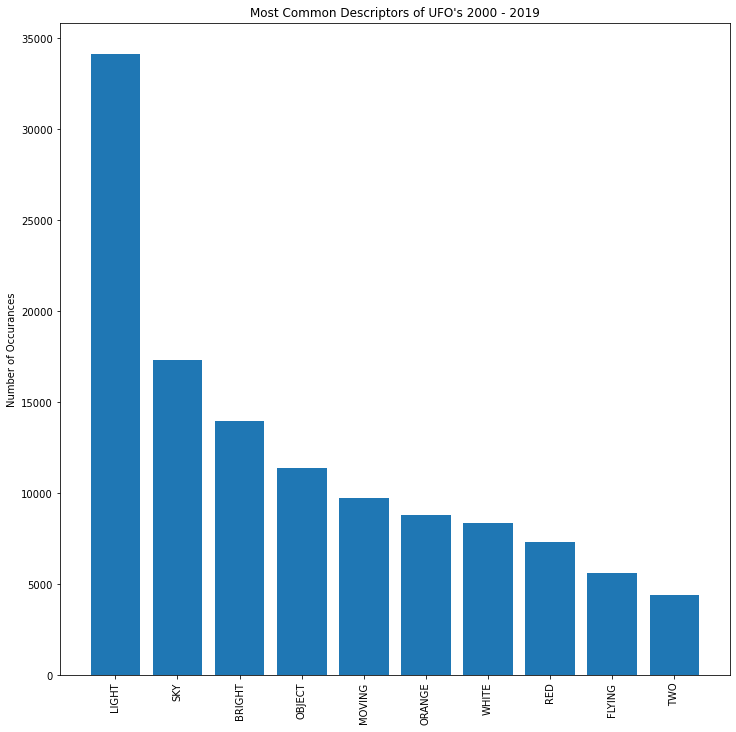

In [44]:
fig, ax = plt.subplots(1,1,figsize = (12,12))

ax.bar(word,freq)
ax.set_xticklabels(word, rotation = 90)
ax.set_title("Most Common Descriptors of UFO's 2000 - 2019")
ax.set_ylabel("Number of Occurances")

The barplot above was constructed using the 10 most common words used in the summaries of UFO sightings from 2020. As you can see, light is by far the most common descriptor. This is followed by sky, bright, object and moving. Following this are three color descriptions and then flying. Perhaps most interesting to me is the final descriptor of two. This implies that there were multiple UFO's from a single sighting. In this analysis, we made the assumption of using common words like "the" "in" "a" and so on. We also excluded words that did not add to the description like "saw" and "seen". Up next we will observe the same description data over the time periods 2000-2004, 2005-2009, 2010-2014, and 2015-2019.

### Over time changes

In [45]:
# Creating data from 2000 - 2004
years = [2000,2001,2000,2003,2004]
bool_series = combined_ungrouped["Year"].isin(years)
data_00_04 = combined_ungrouped[bool_series]

# Extracting column
summaries = data_00_04["summary"]

# Initializing summary dictionary
summaries_dict = freq_dict(summaries)
# Combining light and lights, "sky" and "sky."           
light_count = summaries_dict["LIGHT"] + summaries_dict["LIGHTS"]
summaries_dict["LIGHT"] = light_count
del summaries_dict["LIGHTS"]
sky_count = summaries_dict["SKY"] + summaries_dict["SKY."]
summaries_dict["SKY"] = sky_count
del summaries_dict["SKY."]

# Deleting common words or words that don't makes sense
common_words = ["THE","IN","A","AND","OF","TO","I","WAS","AT","WITH","IT","ON",
               "OVER","THEN","FROM","MY","SAW","SEEN","THAT","VERY","LIKE",
                "SHAPED","NOTE:","NO"]
for word in common_words:
    del summaries_dict[word]

# Getting words and frequency list
word_00_04,freq_00_04 = words_freq(summaries_dict, 10)
    
print(word_00_04)
print(freq_00_04)

['LIGHT', 'OBJECT', 'BRIGHT', 'UFO', 'SKY', 'CRAFT', 'WHITE', 'MOVING', 'LARGE', 'FLYING']
[278, 119, 96, 88, 86, 69, 64, 56, 56, 52]


In [46]:
# Creating data from 2005 - 2009
years = [2005,2006,2007,2008,2009]
bool_series = combined_ungrouped["Year"].isin(years)
data_05_09 = combined_ungrouped[bool_series]

# Extracting column
summaries = data_05_09["summary"]

# Initializing summary dictionary
summaries_dict = freq_dict(summaries)
# Combining light and lights, "sky" and "sky."           
light_count = summaries_dict["LIGHT"] + summaries_dict["LIGHTS"]
summaries_dict["LIGHT"] = light_count
del summaries_dict["LIGHTS"]
sky_count = summaries_dict["SKY"] + summaries_dict["SKY."]
summaries_dict["SKY"] = sky_count
del summaries_dict["SKY."]

# Deleting common words or words that don't makes sense
common_words = ["THE","IN","A","AND","OF","TO","I","WAS","AT","WITH","IT","ON",
               "OVER","THEN","FROM","MY","SAW","SEEN","THAT","VERY","LIKE",
                "SHAPED","NOTE:","NO","((NUFORC","PD))"]
for word in common_words:
    del summaries_dict[word]

# Getting words and frequency list
word_05_09,freq_05_09 = words_freq(summaries_dict, 10)
    
print(word_05_09)
print(freq_05_09)

['LIGHT', 'SKY', 'OBJECT', 'BRIGHT', 'MOVING', 'WHITE', 'RED', 'UFO', 'FLYING', 'ORANGE']
[6786, 3075, 3047, 2747, 1735, 1564, 1114, 1022, 987, 960]


In [47]:
# Creating data from 2010 - 2014
years = [2010,2011,2012,2013,2014]
bool_series = combined_ungrouped["Year"].isin(years)
data_10_14 = combined_ungrouped[bool_series]

# Extracting column
summaries = data_10_14["summary"]

# Initializing summary dictionary
summaries_dict = freq_dict(summaries)
# Combining light and lights, "sky" and "sky."           
light_count = summaries_dict["LIGHT"] + summaries_dict["LIGHTS"]
summaries_dict["LIGHT"] = light_count
del summaries_dict["LIGHTS"]
sky_count = summaries_dict["SKY"] + summaries_dict["SKY."]
summaries_dict["SKY"] = sky_count
del summaries_dict["SKY."]

# Deleting common words or words that don't makes sense
common_words = ["THE","IN","A","AND","OF","TO","I","WAS","AT","WITH","IT","ON",
               "OVER","THEN","FROM","MY","SAW","SEEN","THAT","VERY","LIKE",
                "SHAPED","NOTE:","NO","((NUFORC","PD))"]
for word in common_words:
    del summaries_dict[word]

# Getting words and frequency list
word_10_14,freq_10_14 = words_freq(summaries_dict, 10)
    
print(word_10_14)
print(freq_10_14)

['LIGHT', 'SKY', 'BRIGHT', 'ORANGE', 'OBJECT', 'MOVING', 'RED', 'WHITE', 'FLYING', 'TWO']
[13438, 6991, 5395, 5131, 4131, 3897, 3380, 3025, 2236, 1805]


In [48]:
# Creating data from 2015 - 2019
years = [2015,2016,2017,2018,2019]
bool_series = combined_ungrouped["Year"].isin(years)
data_15_19 = combined_ungrouped[bool_series]

# Extracting column
summaries = data_15_19["summary"]

# Initializing summary dictionary
summaries_dict = freq_dict(summaries)
# Combining light and lights, "sky" and "sky."           
light_count = summaries_dict["LIGHT"] + summaries_dict["LIGHTS"]
summaries_dict["LIGHT"] = light_count
del summaries_dict["LIGHTS"]
sky_count = summaries_dict["SKY"] + summaries_dict["SKY."]
summaries_dict["SKY"] = sky_count
del summaries_dict["SKY."]

# Deleting common words or words that don't makes sense
common_words = ["THE","IN","A","AND","OF","TO","I","WAS","AT","WITH","IT","ON",
               "OVER","THEN","FROM","MY","SAW","SEEN","THAT","VERY","LIKE",
                "SHAPED","NOTE:","NO","((NUFORC","PD))","REPORT))","((ANONYMOUS"]
for word in common_words:
    del summaries_dict[word]

# Getting words and frequency list
word_15_19,freq_15_19 = words_freq(summaries_dict, 10)
    
print(word_15_19)
print(freq_15_19)

['LIGHT', 'SKY', 'BRIGHT', 'OBJECT', 'MOVING', 'WHITE', 'RED', 'ORANGE', 'FLYING', 'UP']
[10899, 5748, 4724, 3284, 3024, 2919, 2397, 2344, 1817, 1450]


<BarContainer object of 10 artists>

[Text(0, 0, 'LIGHT'),
 Text(1, 0, 'OBJECT'),
 Text(2, 0, 'BRIGHT'),
 Text(3, 0, 'UFO'),
 Text(4, 0, 'SKY'),
 Text(5, 0, 'CRAFT'),
 Text(6, 0, 'WHITE'),
 Text(7, 0, 'MOVING'),
 Text(8, 0, 'LARGE'),
 Text(9, 0, 'FLYING')]

Text(0.5, 1.0, "Most Common Descriptors of UFO's 2000 - 2004")

Text(0, 0.5, 'Number of Occurances')

<BarContainer object of 10 artists>

[Text(0, 0, 'LIGHT'),
 Text(1, 0, 'SKY'),
 Text(2, 0, 'OBJECT'),
 Text(3, 0, 'BRIGHT'),
 Text(4, 0, 'MOVING'),
 Text(5, 0, 'WHITE'),
 Text(6, 0, 'RED'),
 Text(7, 0, 'UFO'),
 Text(8, 0, 'FLYING'),
 Text(9, 0, 'ORANGE')]

Text(0.5, 1.0, "Most Common Descriptors of UFO's 2005 - 2009")

Text(0, 0.5, 'Number of Occurances')

<BarContainer object of 10 artists>

[Text(0, 0, 'LIGHT'),
 Text(1, 0, 'SKY'),
 Text(2, 0, 'BRIGHT'),
 Text(3, 0, 'ORANGE'),
 Text(4, 0, 'OBJECT'),
 Text(5, 0, 'MOVING'),
 Text(6, 0, 'RED'),
 Text(7, 0, 'WHITE'),
 Text(8, 0, 'FLYING'),
 Text(9, 0, 'TWO')]

Text(0.5, 1.0, "Most Common Descriptors of UFO's 2010 - 2014")

Text(0, 0.5, 'Number of Occurances')

<BarContainer object of 10 artists>

[Text(0, 0, 'LIGHT'),
 Text(1, 0, 'SKY'),
 Text(2, 0, 'BRIGHT'),
 Text(3, 0, 'OBJECT'),
 Text(4, 0, 'MOVING'),
 Text(5, 0, 'WHITE'),
 Text(6, 0, 'RED'),
 Text(7, 0, 'ORANGE'),
 Text(8, 0, 'FLYING'),
 Text(9, 0, 'UP')]

Text(0.5, 1.0, "Most Common Descriptors of UFO's 2015 - 2019")

Text(0, 0.5, 'Number of Occurances')

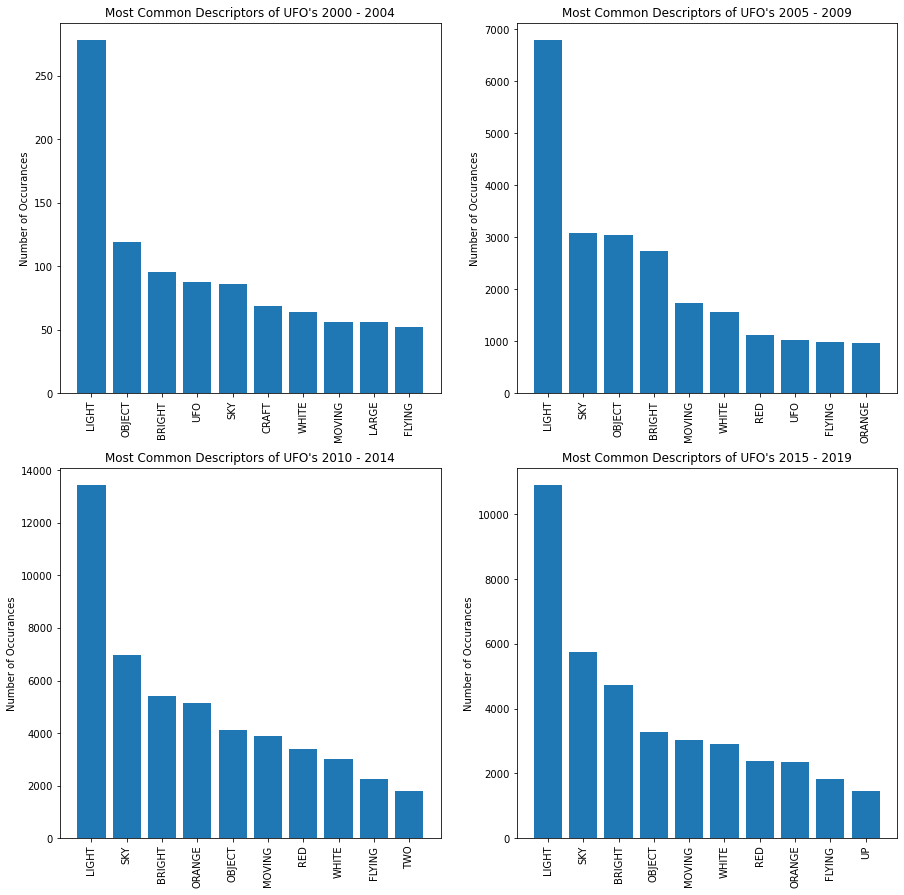

In [49]:
fig, ax = plt.subplots(2,2,figsize = (15,15))

# Plotting years 2000 - 2004
ax[0,0].bar(word_00_04,freq_00_04)
ax[0,0].set_xticklabels(word_00_04, rotation = 90)
ax[0,0].set_title("Most Common Descriptors of UFO's 2000 - 2004")
ax[0,0].set_ylabel("Number of Occurances")

# Plotting years 2005 - 2009
ax[0,1].bar(word_05_09,freq_05_09)
ax[0,1].set_xticklabels(word_05_09, rotation = 90)
ax[0,1].set_title("Most Common Descriptors of UFO's 2005 - 2009")
ax[0,1].set_ylabel("Number of Occurances")

# Plotting years 2010 - 2014
ax[1,0].bar(word_10_14,freq_10_14)
ax[1,0].set_xticklabels(word_10_14, rotation = 90)
ax[1,0].set_title("Most Common Descriptors of UFO's 2010 - 2014")
ax[1,0].set_ylabel("Number of Occurances")

# Plotting years 2015 - 2019
ax[1,1].bar(word_15_19,freq_15_19)
ax[1,1].set_xticklabels(word_15_19, rotation = 90)
ax[1,1].set_title("Most Common Descriptors of UFO's 2015 - 2019")
ax[1,1].set_ylabel("Number of Occurances")

The plots above use the same assumptions as the overall bar charts of excluding common words and words that do not add to the description. The first thing that stands out is that light is the most common descriptor among all time periods. Another interesting observation is that there are significantly less sightings during the earliest time period of 2000-2004. All time periods seem to follow similar patterns. Light is always the most common, followed by a similar 3 or 4 descriptors in different orderes, followed by a few colors, and once again followed by a few other descriptors.

## Frequency of sightings over time

In the section above, we explore a little bit of the UFO sightings over time and now we will take a deeper dive and explore year by year. First, we will explore all alien sightings in the United States and then we will explore by individual states

### Overall country

Text(0.5, 1.0, 'Number of UFO Sightings in the U.S. by year')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

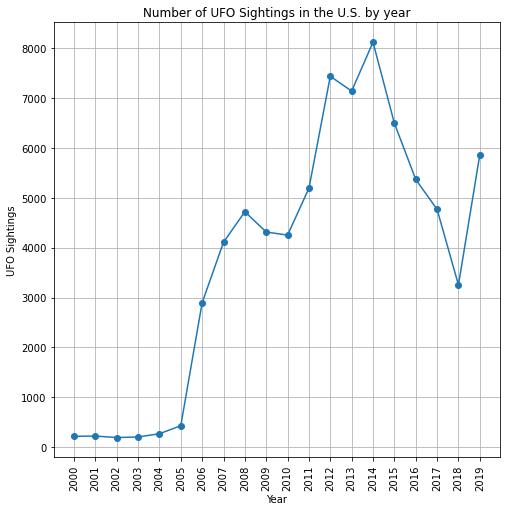

In [50]:
# Initializing frequency list
freq = []

# Adding number of sigtings by year
for i in range(2000,2020):
    yeardata = combined_ungrouped[combined_ungrouped["Year"] == i]
    freq.append(yeardata.shape[0])

# Plotting
fig, ax = plt.subplots(1,1,figsize = (8,8))

ax.plot(range(2000,2020) , freq, marker = "o")
ax.set_title("Number of UFO Sightings in the U.S. by year")
ax.set_ylabel("UFO Sightings")
ax.set_xlabel("Year")
ax.set_xticks(range(2000,2020))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.grid()

As you can see, the alien sightings in the United States remain relatively low from 2000 to 2005. They begin to rapidly increase untul a peak at 2014 and then decrease again. Only to continue inreasing in 2019. The increase in UFO sightings could be due to increased internet access which would allow people to report UFO sightings more easily. We cannot say this for sure but this is certainly something worth exploring.

### By state

In [51]:
combined_data.head()

state state_abbrev  year population_estimate  Sightings  \
0  .Alabama           AL  2000           4,452,173          2   
1  .Alabama           AL  2001           4,467,634          2   
2  .Alabama           AL  2002           4,480,089          2   
3  .Alabama           AL  2003           4,503,491          1   
4  .Alabama           AL  2004           4,530,729          4   

                                              Cities  \
0                                     [Lynn, Sipsey]   
1                           [Hamilton, Guntersville]   
2                            [Orange Beach, Maylene]   
3                                       [Birmingham]   
4  [Birmingham, Gulf Shores, Attalla/Gadsden, Hea...   

                                   Shapes  \
0                        [Triangle, Disk]   
1                          [Other, Light]   
2                          [Other, Light]   
3                              [Cylinder]   
4  [Chevron, Triangle, Triangle, Unknown]   

                                     Durations  \
0                       [15 minutes, 1 minute]   
1                           [5 minutes, 15min]   
2          [crash of air craft, 10-15 seconds]   
3                                     [1 hour]   
4  [15 sec, 5 minutes, 20 minutes, 15 minutes]   

                                           Summaries  \
0  [In February of 2000, I was on routine patrol ...   
1  [Craft downed-emitting powerful-magnificent & ...   
2  [I was listening to a recording on a tape I ha...   
3  [It flew from one end of runway to the other s...   
4  [Large dark chevron, silently passing overhead...   

                                        Posted Dates  \
0         [2011-12-12 00:00:00, 2007-02-01 00:00:00]   
1         [2014-11-06 00:00:00, 2008-04-17 00:00:00]   
2         [2018-06-28 00:00:00, 2012-09-24 00:00:00]   
3                              [2015-04-03 00:00:00]   
4  [2007-11-28 00:00:00, 2009-03-19 00:00:00, 200...   

                                      Sighting Dates  \
0         [2000-02-01 00:00:00, 2000-10-31 00:00:00]   
1         [2001-04-19 00:00:00, 2001-09-05 00:00:00]   
2         [2002-10-23 00:00:00, 2002-12-15 00:00:00]   
3                              [2003-06-30 00:00:00]   
4  [2004-02-01 00:00:00, 2004-08-16 00:00:00, 200...   

                 Sighting Times  
0                [02:30, 20:00]  
1                [20:30, 20:45]  
2                [19:00, 00:00]  
3                       [14:00]  
4  [02:00, 19:00, 21:00, 20:30]

In [52]:
combined_data.state.unique()

array(['.Alabama', '.Alaska', '.Arizona', '.Arkansas', '.California',
       '.Colorado', '.Connecticut', '.Delaware', '.District of Columbia',
       '.Florida', '.Georgia', '.Hawaii', '.Idaho', '.Illinois',
       '.Indiana', '.Iowa', '.Kansas', '.Kentucky', '.Louisiana',
       '.Maine', '.Maryland', '.Massachusetts', '.Michigan', '.Minnesota',
       '.Mississippi', '.Missouri', '.Montana', '.Nebraska', '.Nevada',
       '.New Hampshire', '.New Jersey', '.New Mexico', '.New York',
       '.North Carolina', '.North Dakota', '.Ohio', '.Oklahoma',
       '.Oregon', '.Pennsylvania', '.Rhode Island', '.South Carolina',
       '.South Dakota', '.Tennessee', '.Texas', '.Utah', '.Vermont',
       '.Virginia', '.Washington', '.West Virginia', '.Wisconsin',
       '.Wyoming'], dtype=object)

Text(0.5, 1.0, 'Alabama')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Alaska')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Arizona')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Arkansas')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'California')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Colorado')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Connecticut')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Delaware')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'District of Columbia')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Florida')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Georgia')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Hawaii')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Idaho')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Illinois')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Indiana')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Iowa')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Kansas')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Kentucky')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Louisiana')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Maine')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Maryland')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Massachusetts')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Michigan')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Minnesota')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Mississippi')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Missouri')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Montana')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Nebraska')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Nevada')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'New Hampshire')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'New Jersey')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'New Mexico')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'New York')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'North Carolina')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'North Dakota')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Ohio')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Oklahoma')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Oregon')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Pennsylvania')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Rhode Island')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'South Carolina')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'South Dakota')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Tennessee')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Texas')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Utah')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Vermont')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Virginia')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Washington')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'West Virginia')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Wisconsin')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

Text(0.5, 1.0, 'Wyoming')

Text(0, 0.5, 'UFO Sightings')

Text(0.5, 0, 'Year')

[Text(2000, 0, '2000'),
 Text(2001, 0, '2001'),
 Text(2002, 0, '2002'),
 Text(2003, 0, '2003'),
 Text(2004, 0, '2004'),
 Text(2005, 0, '2005'),
 Text(2006, 0, '2006'),
 Text(2007, 0, '2007'),
 Text(2008, 0, '2008'),
 Text(2009, 0, '2009'),
 Text(2010, 0, '2010'),
 Text(2011, 0, '2011'),
 Text(2012, 0, '2012'),
 Text(2013, 0, '2013'),
 Text(2014, 0, '2014'),
 Text(2015, 0, '2015'),
 Text(2016, 0, '2016'),
 Text(2017, 0, '2017'),
 Text(2018, 0, '2018'),
 Text(2019, 0, '2019')]

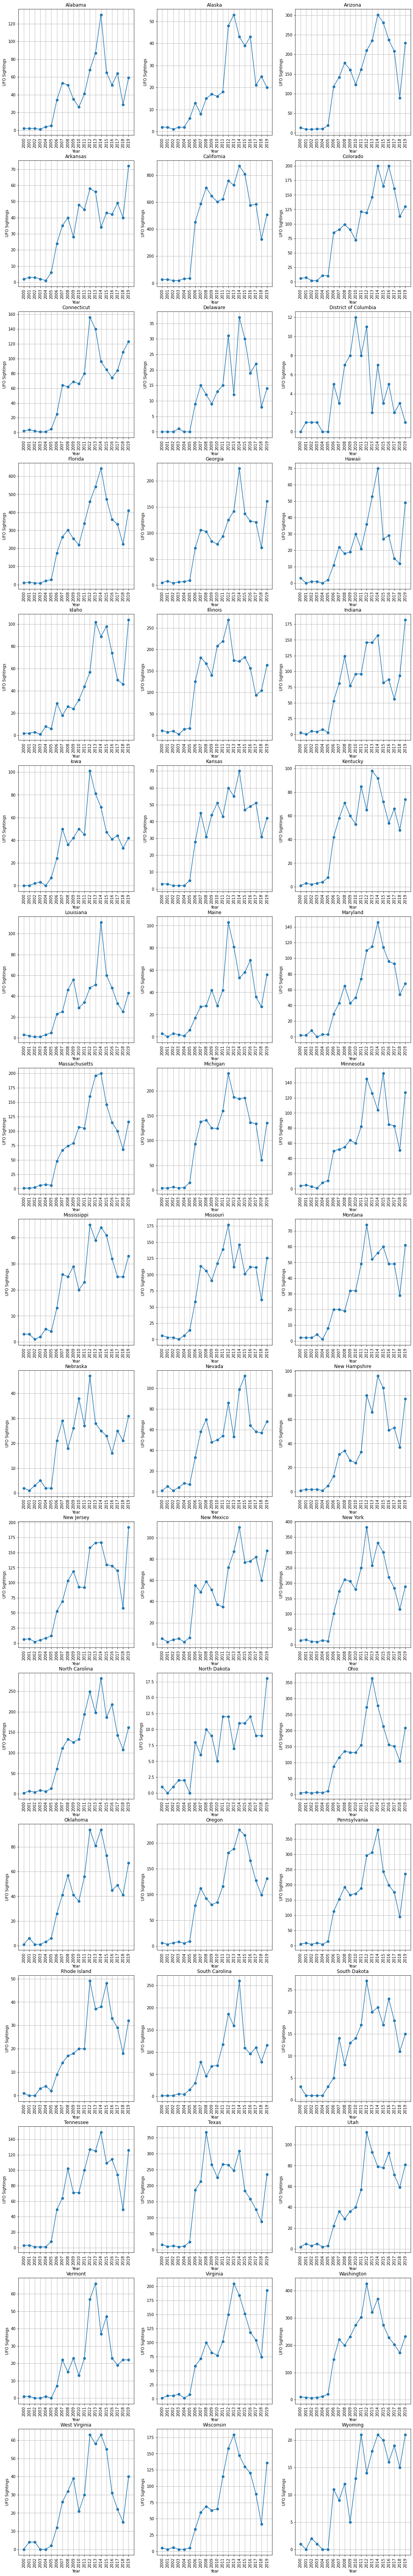

In [53]:
# Tracking which plot we are on to plot to correct place
n = 0

# Initializing figure and axes for subplots
fig, ax = plt.subplots(17,3,figsize = (18,120))

## Plotting for each state
for state in combined_data.state.unique():
    ## Initializing frequency list
    freq = []
    
    # Getting State specific dataframe
    current_state_df = combined_data[combined_data["state"] == state]

    # Adding number of sigtings by year
    for i in range(2000,2020):
        freq.append(int(current_state_df.loc[current_state_df["year"] == i,"Sightings"]))

    ax[n//3,n%3].plot(range(2000,2020) , freq, marker = "o")
    ax[n//3,n%3].set_title(state[1:])
    ax[n//3,n%3].set_ylabel("UFO Sightings")
    ax[n//3,n%3].set_xlabel("Year")
    ax[n//3,n%3].set_xticks(range(2000,2020))
    ax[n//3,n%3].set_xticklabels(ax[n//3,n%3].get_xticks(), rotation = 90)
    ax[n//3,n%3].grid()
    
    n += 1

## Exploratory Analysis of Military Bases
In order to understand the military base data further, the following sections are an exploratory analysis of the summary statistics on types, locations, sizes, and active bases in the US.

In [54]:
plt.set_cmap('Blues')

military.head()

site_name           state    component state_abbrev  \
0           Pohakuloa Training Area          Hawaii  Army Active           HI   
1    Military Ocean Tml Sunny Point  North Carolina  Army Active           NC   
2  Waianae Kai Military Reservation          Hawaii  Army Active           HI   
3                 Picatinny Arsenal      New Jersey  Army Active           NJ   
4             Arlington Service Ctr        Virginia  Navy Active           VA   

  operating_status joint_base  \
0           Active        N/A   
1           Active        N/A   
2           Active        N/A   
3           Active        N/A   
4           Active        N/A   

                                            geometry  \
0  {'type': 'Point', 'coordinates': [-155.6266007...   
1  {'type': 'Point', 'coordinates': [-77.97324120...   
2  {'type': 'Point', 'coordinates': [-158.1910814...   
3  {'type': 'Point', 'coordinates': [-74.54462550...   
4  {'type': 'Point', 'coordinates': [-77.07933502...   

                         geo_point        area  \
0  [19.7144170574, -155.626600781]  205.674769   
1  [34.0182119696, -77.9732412004]   18.030943   
2  [21.4469197196, -158.191081477]    0.021070   
3  [40.9543096396, -74.5446255065]   10.274818   
4  [38.8677348506, -77.0793350205]    0.030300   

                                   recordid               record_timestamp  
0  4cd9c8077a78e15b849f3bcd1635f6ae759d3441  2020-12-31T04:59:25.178-05:00  
1  bd5549100a5578b8d58ebfe5c8e012a98bd3fb7c  2020-12-31T04:59:25.178-05:00  
2  69755f36cb0f4082ea14c0b9aa40aa98ab580c81  2020-12-31T04:59:25.178-05:00  
3  6c32071f38ec8c7cfe59519f041268c821061fd2  2020-12-31T04:59:25.178-05:00  
4  4ece5c62d49245fe9f205ae60042b2233d658ac6  2020-12-31T04:59:25.178-05:00

<Figure size 864x576 with 0 Axes>

### Subquestions:

1. What is the most common type of military base in each state?
2. How many bases are located in each state?

The plot below shows the total number of bases in the 20 states with the most overall bases. California has the largest number of bases total, with 73 bases. In these states, the most common type of base, by frequency, are active Navy bases. Approximately half of the bases located in California are Active Navy bases. We can also see that next most common types of bases are active Army and active AF (Air Force) bases. It is also interesting that California has almost twice as many bases in total than the next state, Texas. 

In [55]:
#group the military df by state and pull the top 20 states with the most military bases
#save the states with the most bases to a list to use on military dataset to pull observations

by_state = military.groupby('state')
top_freq_states = list(by_state['component'].describe().sort_values(by='count', ascending = False).head(20).index)

top_freq = military[military.state.isin(top_freq_states)]

by_state_top_freq = top_freq.groupby('state')
components_by_state = by_state.agg({'component':'count'}).reset_index()

#break downt the base data into value counts of types of bases, create a total column to sort by top number of bases
base_types_by_state = by_state_top_freq.component.value_counts().unstack().fillna(0)
base_types_by_state['total'] = base_types_by_state.iloc[:,:-1].sum(axis=1)
base_types_by_state = base_types_by_state.sort_values(by='total', ascending = True)
base_types_by_state.drop('total',axis=1, inplace = True)
base_types_by_state_cols = list(base_types_by_state.columns)

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Types of Military Bases in States with Most Overall Bases')

Text(0.5, 0, 'Count of Bases')

(-0.5, 19.5)

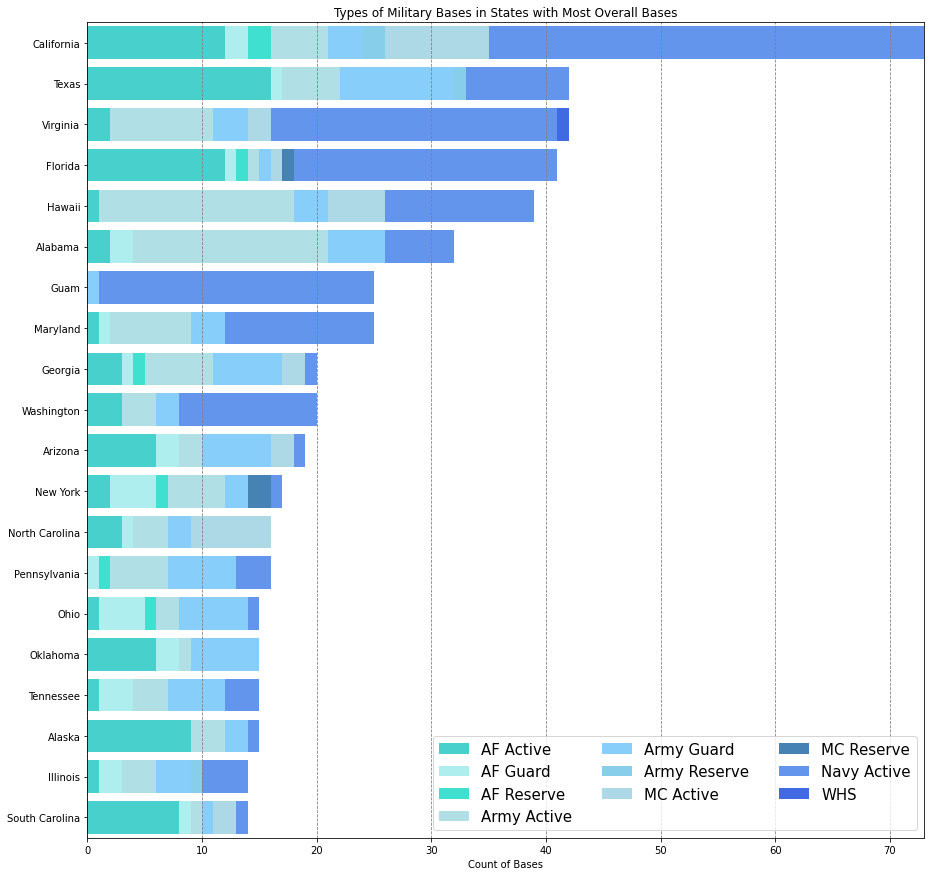

In [56]:
#plot 
fig, ax = plt.subplots(1, figsize=(15,15))

labels = base_types_by_state_cols
colors = ['mediumturquoise','paleturquoise','turquoise','powderblue','lightskyblue','skyblue','lightblue','steelblue',
         'cornflowerblue','royalblue']

left = len(base_types_by_state) * [0]

for idx, name in enumerate(base_types_by_state_cols):
    plt.barh(base_types_by_state.index, base_types_by_state[name], left=left,color=colors[idx])
    left = left + base_types_by_state[name]
    
plt.title('Types of Military Bases in States with Most Overall Bases')
plt.legend(labels, bbox_to_anchor = ([0,0,1,0]), loc='lower right',ncol=3,prop={'size':15})
plt.xlabel('Count of Bases')

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.rcParams.update({'font.size': 20})
plt.show()

In [57]:
ref_mil_copy = reformatted_military.copy()
ref_mil_copy['total'] = ref_mil_copy.iloc[:,1:-1].sum(axis=1)
ref_mil_copy.head()

state_abbrev  AFActive_Active  AFActive_Inactive  AFGuard_Active  \
0           AK              9.0                0.0             0.0   
1           AL              2.0                0.0             2.0   
2           AR              1.0                0.0             1.0   
3           AZ              6.0                0.0             2.0   
4           CA              9.0                3.0             2.0   

   AFReserve_Active  ArmyActive_Active  ArmyActive_Inactive  ArmyGuard_Active  \
0               0.0                3.0                  0.0               1.0   
1               0.0               17.0                  0.0               5.0   
2               0.0                1.0                  0.0               2.0   
3               0.0                2.0                  0.0               6.0   
4               2.0                4.0                  1.0               3.0   

   ArmyGuard_Inactive  ArmyReserve_Active  MCActive_Active  MCReserve_Active  \
0                 1.0                 0.0              0.0               0.0   
1                 0.0                 0.0              0.0               0.0   
2                 0.0                 0.0              0.0               0.0   
3                 0.0                 0.0              2.0               0.0   
4                 0.0                 2.0              9.0               0.0   

   NavyActive_Active  NavyInactive_Active  WHS_Active  record_year  total  
0                1.0                  0.0         0.0         2019   15.0  
1                6.0                  0.0         0.0         2019   32.0  
2                0.0                  0.0         0.0         2019    5.0  
3                1.0                  0.0         0.0         2019   19.0  
4               38.0                  0.0         0.0         2019   73.0

In [58]:
fig = px.choropleth(ref_mil_copy, locations=ref_mil_copy['state_abbrev'],locationmode='USA-states',
                   color='total',range_color=(0,80),scope='usa',labels={'total':'Total # Bases'})
fig.update_layout(title={'text':'Total Number of Military Bases by US State', 'xanchor':'center','x':0.5})
fig.show()

## Subquestion:

3. What is the breakdown of active and inactive bases in each state?

The plot below shows that the number of inactive bases across states is small in comparison to active bases. In many states, there are only active bases. California and Indiana have the highest proportion of inactive bases, but even these are only a small fraction of the overall number of bases in both states. This tells me that the majority of the military base data we are working with consists of active bases, with only a few inactive ones.

In [59]:
state_by_active = by_state['operating_status'].value_counts().unstack().fillna(0)
state_by_active['total'] = state_by_active.iloc[:,:].sum(axis=1)
state_by_active.sort_values(by='total', inplace=True)

state_by_active.head()

operating_status  Active  Inactive  total
state                                    
Wyoming              3.0       0.0    3.0
Delaware             4.0       0.0    4.0
New Hampshire        4.0       0.0    4.0
Arkansas             5.0       0.0    5.0
Montana              5.0       0.0    5.0

<AxesSubplot:xlabel='state'>

Text(0.5, 1.0, 'Total Bases vs. Number of Inactive Bases')

Text(0, 0.5, 'Count of Bases')

Text(0.5, 0, 'State')

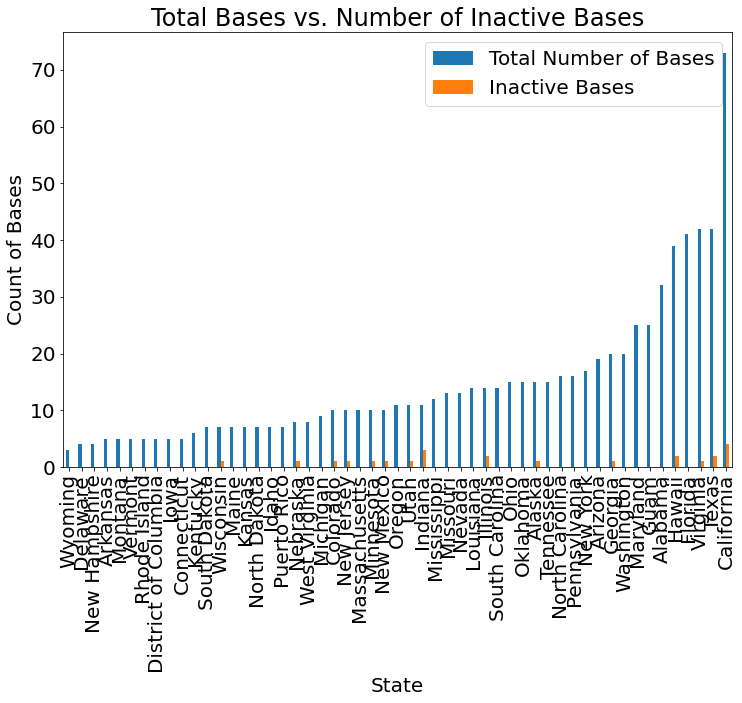

In [60]:
state_by_active.plot(y=['total', 'Inactive'], kind='bar')
plt.title('Total Bases vs. Number of Inactive Bases')
plt.ylabel('Count of Bases')
plt.xlabel('State')
plt.legend(labels = ['Total Number of Bases', 'Inactive Bases'])
plt.rcParams.update({'font.size': 12})
pass

## Subquestion:

4. What are the overall statistics for military base types across all states? Which are the most common in the country?

The most common type of military base in the United States is active Naval bases, with over 200 bases. The next most frequently occuring base type in the US are Army Guard, followed by active Air Force and Army bases. The least common base type is Washington Headquarters Services, which is only located in Northern Virginia. 

By looking at this plot, we can also see that there are not many reserve bases across the country. The total number of reserve bases overall is 21, as is seen for the AF, Army, and Marine Corps reserve bases below. 


In [61]:
military['component'].value_counts()

Navy Active     208
Army Guard      177
AF Active       137
Army Active     134
AF Guard         68
MC Active        30
AF Reserve       10
Army Reserve      8
MC Reserve        3
WHS               1
Name: component, dtype: int64

<AxesSubplot:>

Text(0.5, 1.0, 'Frequency of Military Base Types in the United States')

Text(0, 0.5, 'Count of Bases')

Text(0.5, 0, 'Type of Military Branch Base')

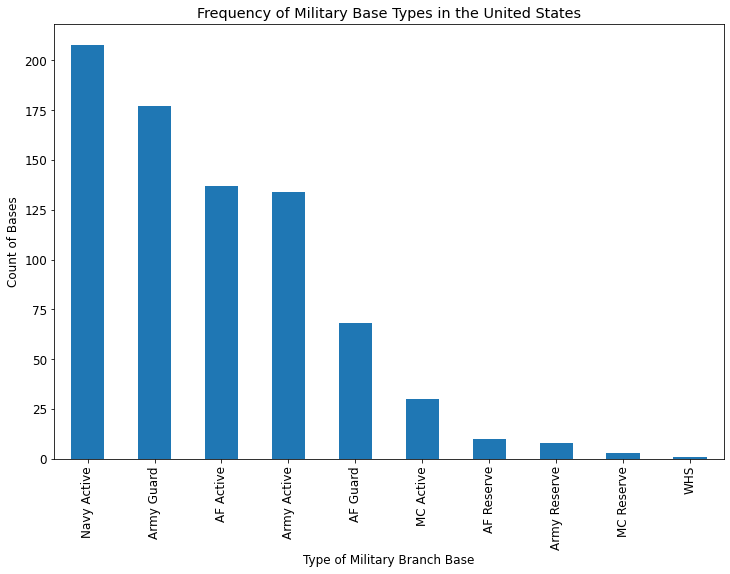

In [62]:
military['component'].value_counts().plot(kind='bar')
plt.title('Frequency of Military Base Types in the United States')
plt.ylabel('Count of Bases')
plt.xlabel('Type of Military Branch Base')
plt.show()

## Subquestion

5. Where are the largest military bases in the US? 

In order to analyze the largest military bases in the US, I first grouped the bases by state. Here we are interested in the average area of all bases located in that state. The state with the greatest average size (in square miles) of military bases was Nevada with roughly 402 square miles. 

In [63]:
#pull a table of mean areas for each state from the grouped dataframe
mean_area = by_state['area'].agg('mean')

#sanity check the means table
california = by_state.get_group('California')
california['area'].mean() == mean_area['California']

True

In [64]:
mean_area = mean_area.to_frame().sort_values(by='area', ascending = False)
mean_area

area
state                           
Nevada                402.907575
New Mexico            381.886409
Utah                  259.370276
Arizona               223.637708
California             89.119905
Alaska                 83.662414
Georgia                76.356125
Colorado               67.096459
Idaho                  58.013451
Texas                  55.014288
Kentucky               44.831772
Wyoming                44.327083
North Carolina         37.167327
Arkansas               36.720136
Louisiana              33.344855
Washington             33.288336
Kansas                 32.211124
Michigan               27.601536
Florida                25.302895
Mississippi            22.334042
Indiana                21.915729
Iowa                   17.135306
Oklahoma               14.806232
Tennessee              14.647157
Wisconsin              14.246096
Oregon                 14.033895
South Carolina         12.296874
New York               11.869504
Missouri                9.978365
Montana                 9.796524
Virginia                9.448801
New Jersey              9.125198
Minnesota               8.577787
Hawaii                  8.310376
Alabama                 7.637520
Maryland                6.171297
North Dakota            5.013928
Massachusetts           4.771124
Pennsylvania            3.885854
Vermont                 3.778523
Puerto Rico             3.287364
Ohio                    3.175626
Maine                   3.140208
Illinois                2.607049
Guam                    2.192403
West Virginia           2.162621
Nebraska                1.606916
South Dakota            1.406605
New Hampshire           1.315228
Delaware                1.209546
Connecticut             0.863557
Rhode Island            0.448267
District of Columbia    0.415686

<AxesSubplot:xlabel='state'>

Text(0.5, 1.0, 'Average Area of Military Bases by State')

Text(0, 0.5, 'Base Area in Square Miles')

Text(0.5, 0, 'State')

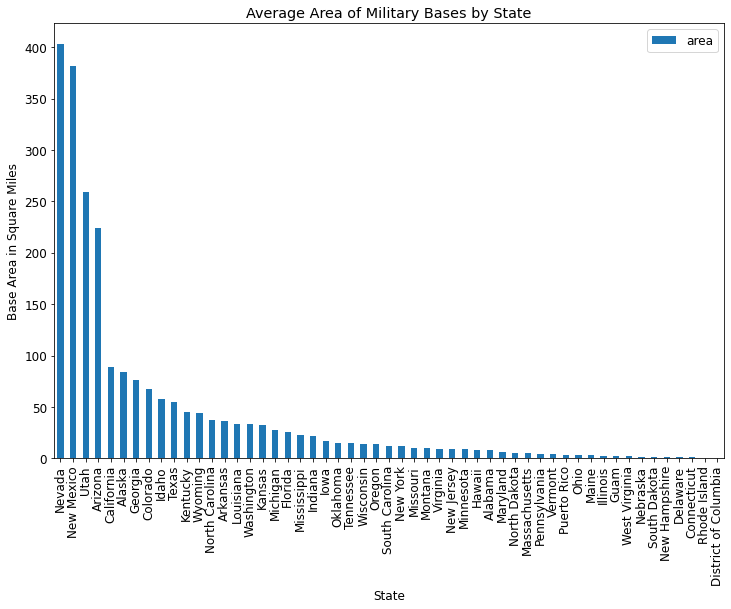

In [65]:
#plot average areas for each state
mean_area.plot(y='area', kind='bar')
plt.title('Average Area of Military Bases by State')
plt.ylabel('Base Area in Square Miles')
plt.xlabel('State')
pass

## Subquestion

6. Which states have the most military bases per capita? Normalized with population data.

In [66]:
ref_mil_copy.head()
ref_mil_copy.shape

state_abbrev  AFActive_Active  AFActive_Inactive  AFGuard_Active  \
0           AK              9.0                0.0             0.0   
1           AL              2.0                0.0             2.0   
2           AR              1.0                0.0             1.0   
3           AZ              6.0                0.0             2.0   
4           CA              9.0                3.0             2.0   

   AFReserve_Active  ArmyActive_Active  ArmyActive_Inactive  ArmyGuard_Active  \
0               0.0                3.0                  0.0               1.0   
1               0.0               17.0                  0.0               5.0   
2               0.0                1.0                  0.0               2.0   
3               0.0                2.0                  0.0               6.0   
4               2.0                4.0                  1.0               3.0   

   ArmyGuard_Inactive  ArmyReserve_Active  MCActive_Active  MCReserve_Active  \
0                 1.0                 0.0              0.0               0.0   
1                 0.0                 0.0              0.0               0.0   
2                 0.0                 0.0              0.0               0.0   
3                 0.0                 0.0              2.0               0.0   
4                 0.0                 2.0              9.0               0.0   

   NavyActive_Active  NavyInactive_Active  WHS_Active  record_year  total  
0                1.0                  0.0         0.0         2019   15.0  
1                6.0                  0.0         0.0         2019   32.0  
2                0.0                  0.0         0.0         2019    5.0  
3                1.0                  0.0         0.0         2019   19.0  
4               38.0                  0.0         0.0         2019   73.0

(53, 17)

In [67]:
census_wide.head()
census_wide.shape

state state_abbrev        2000        2001        2002        2003  \
0     .Alabama           AL   4,452,173   4,467,634   4,480,089   4,503,491   
1      .Alaska           AK     627,963     633,714     642,337     648,414   
2     .Arizona           AZ   5,160,586   5,273,477   5,396,255   5,510,364   
3    .Arkansas           AR   2,678,588   2,691,571   2,705,927   2,724,816   
4  .California           CA  33,987,977  34,479,458  34,871,843  35,253,159   

         2004        2005        2006        2007        2008        2009  \
0   4,530,729   4,569,805   4,628,981   4,672,840   4,718,206   4,757,938   
1     659,286     666,946     675,302     680,300     687,455     698,895   
2   5,652,404   5,839,077   6,029,141   6,167,681   6,280,362   6,343,154   
3   2,749,686   2,781,097   2,821,761   2,848,650   2,874,554   2,896,843   
4  35,574,576  35,827,943  36,021,202  36,250,311  36,604,337  36,961,229   

         2010        2011        2012        2013        2014        2015  \
0   4,785,437   4,799,069   4,815,588   4,830,081   4,841,799   4,852,347   
1     713,910     722,128     730,443     737,068     736,283     737,498   
2   6,407,172   6,472,643   6,554,978   6,632,764   6,730,413   6,829,676   
3   2,921,964   2,940,667   2,952,164   2,959,400   2,967,392   2,978,048   
4  37,319,502  37,638,369  37,948,800  38,260,787  38,596,972  38,918,045   

         2016        2017        2018        2019  
0   4,863,525   4,874,486   4,887,681   4,903,185  
1     741,456     739,700     735,139     731,545  
2   6,941,072   7,044,008   7,158,024   7,278,717  
3   2,989,918   3,001,345   3,009,733   3,017,804  
4  39,167,117  39,358,497  39,461,588  39,512,223

(51, 22)

In [68]:
ref_mil_copy.sort_values(by='state_abbrev',inplace=True)
census_wide.sort_values(by='state_abbrev',inplace=True)

#check the states listed in each dataframe. There are two territories in the military dataset which we can remove (Guam/PR)
set(ref_mil_copy.state_abbrev) == set(census_wide.state_abbrev)

False

In [69]:
#combine the census data with the military base data, drop PR and Guam and pull the columns we are interested in
merged = ref_mil_copy.merge(census_wide, how='left')
merged = merged.drop([11,40])
states_area_pop = merged.loc[:,['state_abbrev','total','2019']]

#remove the commas in the population data column and transform to numeric for per capita calculations
states_area_pop.replace(',','', regex=True, inplace=True)
states_area_pop["2019"] = pd.to_numeric(states_area_pop["2019"])

#create new column which is a calculation of bases in each state per capita 
states_area_pop['bases_per_capita'] = states_area_pop['total']/states_area_pop['2019']

states_area_pop.sort_values(by='bases_per_capita', ascending=False, inplace=True)
states_area_pop = states_area_pop.set_index('state_abbrev')
states_area_pop.head()

total     2019  bases_per_capita
state_abbrev                                  
HI             39.0  1415872          0.000028
AK             15.0   731545          0.000021
ND              7.0   762062          0.000009
VT              5.0   623989          0.000008
SD              7.0   884659          0.000008

<AxesSubplot:xlabel='state_abbrev'>

Text(0.5, 1.0, 'Bases Per Capita')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Bases Per Capita')

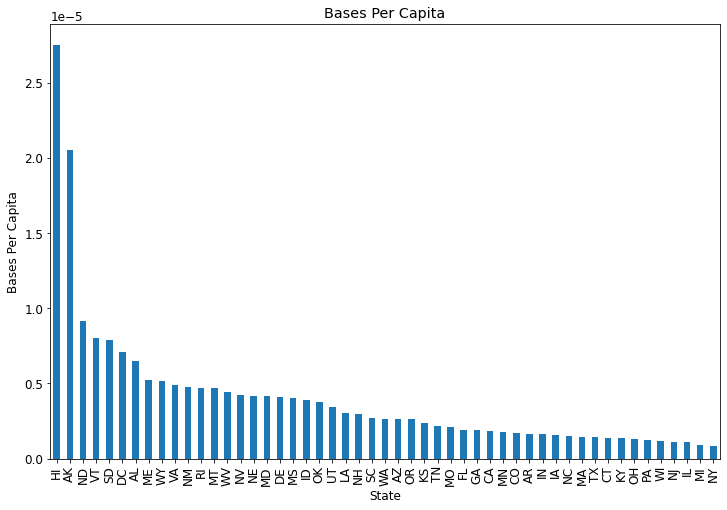

In [70]:
#plot
states_area_pop.plot(y='bases_per_capita', kind='bar',legend=None)
plt.title('Bases Per Capita')
plt.xlabel('State')
plt.ylabel('Bases Per Capita')
plt.rcParams.update({'font.size': 10})
pass

# UFO Sightings v. State Population Analysis

## Subset to only include data needed for analysis

In [71]:
# Subset
ufo_subset = combined_ungrouped.iloc[:, 0:11]
ufo_subset.columns = ufo_subset.columns.str.lower()
ufo_subset["year"] = ufo_subset["year"].astype(str)

# Change Column Type 
ufo_subset = ufo_subset \
    .assign(date = pd.to_datetime(ufo_subset.date, format="%Y-%m-%d"),
            posted = pd.to_datetime(ufo_subset.posted, format="%Y-%m-%d"),
            population_estimate = pd.to_numeric(ufo_subset.population_estimate.str.replace(",", "")))

# Rename Column
ufo_subset.rename(columns = {"state_abbrev_ufo" : "state"}, inplace=True)

In [72]:
ufo_subset.head()

ufo_subset.describe(include = "all")

datetime             city     shape    duration  \
0  1/31/00 21:00   Cape Canaveral     Light    1 minute   
1  1/19/00 03:00  West Palm Beach       Egg  20 minutes   
2  1/17/00 21:40           Orland  Triangle  10 minutes   
3  1/15/00 22:30       West Fargo    Sphere  15 minutes   
4  1/15/00 20:00     Lake Charles     Light  40 minutes   

                                             summary     posted       date  \
0  Glowing green light came up right side of movi... 2007-10-08 2000-01-31   
1                     Grey visitation and abduction. 2019-12-01 2000-01-19   
2  Small triangular object flying low to ground f... 2007-06-12 2000-01-17   
3  Bright glowing red orb. Did not emit any smoke... 2006-10-30 2000-01-15   
4  There was a UFO in Lake Charles, Louisiana in ... 2009-01-10 2000-01-15   

    time  year state  population_estimate  
0  21:00  2000    FL           16047515.0  
1  03:00  2000    FL           16047515.0  
2  21:40  2000    CA           33987977.0  
3  22:30  2000    ND             642023.0  
4  20:00  2000    LA            4471885.0

datetime     city  shape   duration         summary  \
count           82194    82085  79360      78698           82160   
unique          69362    15054     21       7087           80371   
top     11/7/15 18:00  Phoenix  Light  5 minutes  MADAR Node 142   
freq              104      442  17745       5936              48   
first             NaN      NaN    NaN        NaN             NaN   
last              NaN      NaN    NaN        NaN             NaN   
mean              NaN      NaN    NaN        NaN             NaN   
std               NaN      NaN    NaN        NaN             NaN   
min               NaN      NaN    NaN        NaN             NaN   
25%               NaN      NaN    NaN        NaN             NaN   
50%               NaN      NaN    NaN        NaN             NaN   
75%               NaN      NaN    NaN        NaN             NaN   
max               NaN      NaN    NaN        NaN             NaN   

                     posted                 date   time   year  state  \
count                 82193                82194  81504  82194  75471   
unique                  416                 6247   1433     21     51   
top     2020-06-25 00:00:00  2015-11-07 00:00:00  22:00   2014     CA   
freq                   1638                  288   4424   8125   8949   
first   2006-05-15 00:00:00  2000-01-01 00:00:00    NaN    NaN    NaN   
last    2021-03-31 00:00:00  2020-12-31 00:00:00    NaN    NaN    NaN   
mean                    NaN                  NaN    NaN    NaN    NaN   
std                     NaN                  NaN    NaN    NaN    NaN   
min                     NaN                  NaN    NaN    NaN    NaN   
25%                     NaN                  NaN    NaN    NaN    NaN   
50%                     NaN                  NaN    NaN    NaN    NaN   
75%                     NaN                  NaN    NaN    NaN    NaN   
max                     NaN                  NaN    NaN    NaN    NaN   

        population_estimate  
count          7.547100e+04  
unique                  NaN  
top                     NaN  
freq                    NaN  
first                   NaN  
last                    NaN  
mean           1.248902e+07  
std            1.119739e+07  
min            4.943000e+05  
25%            4.841799e+06  
50%            7.751000e+06  
75%            1.905324e+07  
max            3.951222e+07

## Analysis 0 - Number of UFO Sightings Per Capita
- UFO sightings in general is a very rare event!!
- Each year, out of 100,000 people residing the in the US, there is on average only 1.15 UFO sightings in the US.

In [73]:
per_capita = ufo_subset\
    .assign(population_estimate = ufo_subset.population_estimate/100000,
            year = pd.DatetimeIndex(ufo_subset.year))\
    .sort_values(["state","year"])\
    .groupby(["state"], as_index=False)\
    .agg({"datetime": "count",
          "population_estimate" : "last"})

print(f"Each year, there is on average only "
      f"{per_capita.datetime.sum()/per_capita.population_estimate.sum()/20 :0.3} "
      f"UFO sightings per 100,000 people in the US.")

Each year, there is on average only 1.15 UFO sightings per 100,000 people in the US.


## Analysis 1 - UFO Sightings and State Population
- Intuitively, the more densely populated state has reported more sightings. This is most likely due to the fact that the more densely populated states simply have more people staring at the sky. 
- Without any surprise, California is the far right dot in the graph below. As you can probably tell this graph, the two most populated states CA and TX have very different relationship with UFO. 
- While they both on aggregate report a decent number of UFO sightings. California people seem to report more than average given its population on UFO sightings and Texas people on the other hand appear to report less than average.

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

<AxesSubplot:xlabel='population_estimate', ylabel='num_of_obs'>

Text(0.5, 1.0, 'Number of Observations v. Population Estimate')

Text(0, 0.5, 'Number of Observations')

Text(0.5, 0, 'Population Estimate (in 100,000)')

(0.0, 400.0)

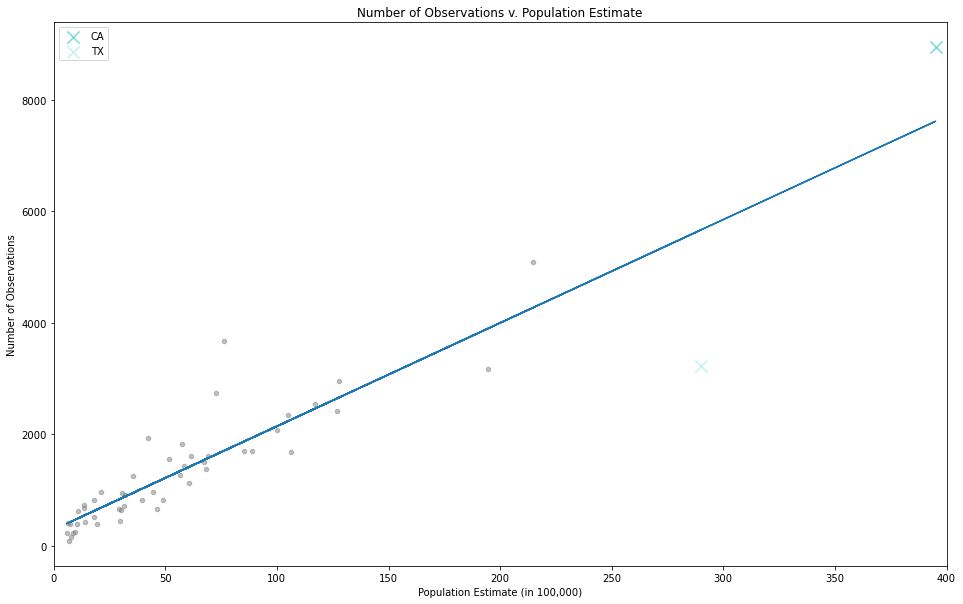

In [74]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 10)
fig.subplots_adjust(hspace=0.5)


sightings_scatter = ufo_subset\
    .assign(population_estimate = ufo_subset.population_estimate/100000,
            year = pd.DatetimeIndex(ufo_subset.year))\
    .sort_values(["state","year"])\
    .groupby(["state"], as_index=False)\
    .agg({"datetime": "count",
          "population_estimate" : "last"})\
    .rename(columns = {"datetime" : "num_of_obs"})


focus_states = ["CA", "TX"]
color_scheme = ["mediumturquoise", "paleturquoise"]

for i,j in sightings_scatter.groupby("state"):
    color = color_scheme[focus_states.index(i)] if i in focus_states else "grey"    
    alpha = 0.75 if i in focus_states else 0.5
    label = i if i in focus_states else "_no_legend_"
    width = 4 if i in focus_states else 2
    size = 150 if i in focus_states else 20
    marker = "x" if i in focus_states else "o"
    
    j.plot(x="population_estimate", y="num_of_obs", ax=ax, color=color, kind="scatter", 
           label=label, alpha=alpha, s=size, marker = marker)

m, b = np.polyfit(sightings_scatter.population_estimate, sightings_scatter.num_of_obs, 1)

plt.plot(sightings_scatter.population_estimate, m*sightings_scatter.population_estimate + b)   
    
ax.set_title("Number of Observations v. Population Estimate")
ax.set_ylabel("Number of Observations")
ax.set_xlabel("Population Estimate (in 100,000)")
ax.set_xlim(0, 400)
plt.show()

## Analysis 2 - Number of Observation Overtime
- CA and TX - confirmed with what we saw earlier. TX is in fact the worst state to spot an UFO.
- While one would expect UFO sightings are more frequent among states where UFO conspiracy theories are most popular - states like Nevada, where Area 51 is located, or New Mexico, where Roswell is located.
- These are in fact among the states with more number of sightings. However, they are not the highest.
- Vermont, Montana, and Alaska are actually top three states with the most UFO sightings per 100k people.

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

<AxesSubplot:xlabel='year'>

Text(0.5, 1.0, 'Number of Observations Overtime')

Text(0, 0.5, 'Number of Observations Per 100K People')

Text(0.5, 0, 'Year')

(0.0, 70.0)

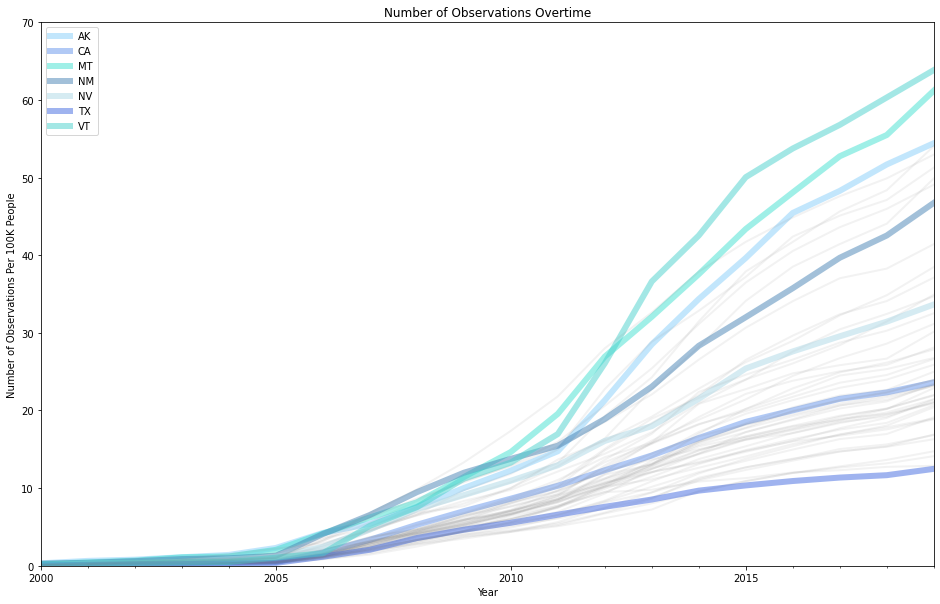

In [75]:
num_overtime = ufo_subset\
    .assign(population_estimate = ufo_subset.population_estimate/100000,
            year = pd.DatetimeIndex(ufo_subset.year))\
    .sort_values(["state","year"])\
    .groupby(["state", "year"], as_index=False)\
    .agg({"datetime": "count",
          "population_estimate" : "last"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .assign(num_of_obs_wt = lambda x: x.num_of_obs/x.population_estimate)\
    .sort_values(["state","year"])\
    .groupby("state", as_index=False)\
    .apply(lambda x: x.assign(cumsum_of_obs_wt = x.num_of_obs_wt.cumsum()))

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 10)

focus_states = ["VT", "MT", "AK", "NV", "NM", "CA", "TX"]
color_scheme = ['mediumturquoise', 'turquoise', 'lightskyblue', 
                'lightblue','steelblue', 'cornflowerblue','royalblue']

for i,j in num_overtime.groupby("state"):
    color = color_scheme[focus_states.index(i)] if i in focus_states else "grey"    
    alpha = 0.5 if i in focus_states else 0.1
    label = i if i in focus_states else "_no_legend_"
    width = 6 if i in focus_states else 2
    
    j.plot(x="year", y="cumsum_of_obs_wt", ax=ax, color=color, kind="line", 
           label=label, alpha=alpha, linewidth = width)
    
ax.set_title("Number of Observations Overtime")
ax.set_ylabel("Number of Observations Per 100K People")
ax.set_xlabel("Year")
ax.set_ylim(bottom=0, top=70)
plt.show()

## Analysis 3 - UFO Shape
- Not much difference between the top states and the rest in terms of UFO shape observed and description summary details.
- As you can probably tell, if you want to have a higher chance to see an UFO, your best shot is to go to states such as Vermont, Montana, Alaska, New Hampshire, or Washington. 
- What do you expect to see? - Let's explore what people see in these states.
- If you want to see the traditional disk type of UFO, you should go to Washington but Washington only!

In [76]:
focus_states = ["VT", "MT", "AK", "NH", "WA"]

shape = ufo_subset\
    .assign(top_state = np.where(ufo_subset.state.isin(focus_states), "Y", "N"))\
    .groupby(["top_state", "shape"])\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "num_of_obs"})\
    .groupby(level=0, as_index=False)\
    .apply(lambda x: x.num_of_obs/x.num_of_obs.sum() * 100)\
    .reset_index()\
    .drop("level_0", axis=1)\
    .groupby("top_state", as_index=False)\
    .apply(lambda x: x.sort_values("num_of_obs", ascending=False).head(15))\
    .reset_index()

shape

length_of_desc = ufo_subset\
    .assign(top_state = np.where(ufo_subset.state.isin(focus_states), "Y", "N"),
            length_of_desc = ufo_subset.summary.str.len())\
    .groupby("top_state")\
    .agg({"length_of_desc": "mean"})\
    .rename(columns = {"length_of_desc" : "mean_summary_len"})

length_of_desc

level_0  level_1 top_state      shape  num_of_obs
0         0       13         N      Light   22.211528
1         0        3         N     Circle   12.112298
2         0       19         N   Triangle    9.070329
3         0       10         N   Fireball    8.275946
4         0       20         N    Unknown    7.104707
5         0       17         N     Sphere    7.039638
6         0       14         N      Other    6.620757
7         0       15         N       Oval    4.341991
8         0        8         N       Disk    4.327079
9         0       12         N  Formation    3.711636
10        0        0         N   Changing    2.559375
11        0        2         N      Cigar    2.231320
12        0       11         N      Flash    1.954777
13        0       16         N  Rectangle    1.854463
14        0        6         N   Cylinder    1.569786
15        1       34         Y      Light   24.320458
16        1       24         Y     Circle   11.051502
17        1       31         Y   Fireball    8.619456
18        1       40         Y   Triangle    8.458512
19        1       41         Y    Unknown    8.136624
20        1       38         Y     Sphere    7.242489
21        1       35         Y      Other    6.312589
22        1       36         Y       Oval    4.488555
23        1       29         Y       Disk    3.826896
24        1       33         Y  Formation    3.308298
25        1       21         Y   Changing    2.628755
26        1       32         Y      Flash    2.360515
27        1       23         Y      Cigar    1.680973
28        1       37         Y  Rectangle    1.537911
29        1       28         Y    Diamond    1.502146

mean_summary_len
top_state                  
N                 80.659634
Y                 79.199414

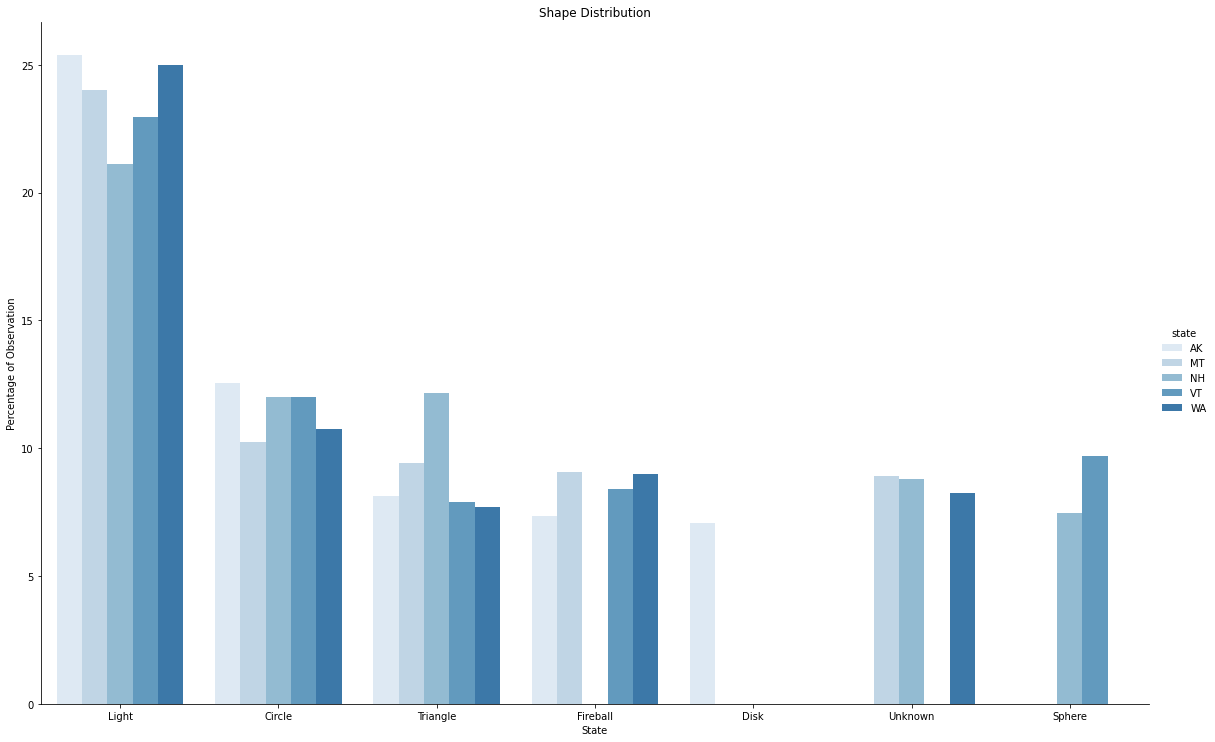

In [77]:
focus_states = ["VT", "MT", "AK", "NH", "WA"]

shape_n = ufo_subset[ufo_subset.state.isin(focus_states)]\
    .groupby(["state", "shape"])\
    .agg({"datetime": "count"})\
    .rename(columns = {"datetime" : "perc_of_obs"})\
    .groupby(level=0, as_index=False)\
    .apply(lambda x: x.perc_of_obs/x.perc_of_obs.sum() * 100)\
    .reset_index()\
    .drop("level_0", axis=1)\
    .groupby("state", as_index=False)\
    .apply(lambda x: x.sort_values("perc_of_obs", ascending=False).head(5))\
    .reset_index()

sns.set_palette("Blues")

sns.catplot(x="shape", y="perc_of_obs", hue = "state", data = shape_n, kind = "bar", height = 10, aspect = 16/10)\
    .set(title="Shape Distribution", xlabel="State", ylabel="Percentage of Observation")

# UFO Sightings v. Military Base
- Base question: What are the trends in sightings corresponding to military base variables?

In [78]:
combined_ungrouped.head(3)

datetime             city     shape    duration  \
0  1/31/00 21:00   Cape Canaveral     Light    1 minute   
1  1/19/00 03:00  West Palm Beach       Egg  20 minutes   
2  1/17/00 21:40           Orland  Triangle  10 minutes   

                                             summary     posted       date  \
0  Glowing green light came up right side of movi... 2007-10-08 2000-01-31   
1                     Grey visitation and abduction. 2019-12-01 2000-01-19   
2  Small triangular object flying low to ground f... 2007-06-12 2000-01-17   

    time  Year state_abbrev_ufo population_estimate  AFActive_Active  \
0  21:00  2000               FL          16,047,515              NaN   
1  03:00  2000               FL          16,047,515              NaN   
2  21:40  2000               CA          33,987,977              NaN   

   AFActive_Inactive  AFGuard_Active  AFReserve_Active  ArmyActive_Active  \
0                NaN             NaN               NaN                NaN   
1                NaN             NaN               NaN                NaN   
2                NaN             NaN               NaN                NaN   

   ArmyActive_Inactive  ArmyGuard_Active  ArmyGuard_Inactive  \
0                  NaN               NaN                 NaN   
1                  NaN               NaN                 NaN   
2                  NaN               NaN                 NaN   

   ArmyReserve_Active  MCActive_Active  MCReserve_Active  NavyActive_Active  \
0                 NaN              NaN               NaN                NaN   
1                 NaN              NaN               NaN                NaN   
2                 NaN              NaN               NaN                NaN   

   NavyInactive_Active  WHS_Active  
0                  NaN         NaN  
1                  NaN         NaN  
2                  NaN         NaN

In [79]:
comb_final = combined_ungrouped.loc[combined_ungrouped['Year'] == 2019]
comb_final

datetime          city     shape     duration  \
69605  1/31/19 21:00     Las Vegas     Light   10 minutes   
69606  1/31/19 20:27       Lumpkin     Other     Not sure   
69607  1/31/19 20:03   Winterhaven    Circle  2-3 seconds   
69608  1/31/19 18:00        Albany  Fireball   20 minutes   
69609  1/31/19 18:00     Hollywood    Circle    6 minutes   
...              ...           ...       ...          ...   
75467  12/1/19 06:00  Mcleansville      Disk    3 minutes   
75468  12/1/19 04:48      Newburgh       NaN          NaN   
75469  12/1/19 01:25    Alexandria       NaN          NaN   
75470  12/1/19 00:30      Woolwich     Other   20 minutes   
75471  12/1/19 00:06       Phoenix  Changing  1.5 minutes   

                                                 summary     posted  \
69605  Pink light in sky making light orbs you could ... 2019-02-01   
69606  Unidentifiable shape hovering over field in Lu... 2019-02-01   
69607  Bright white round with white/orange sparks ta... 2019-02-22   
69608  Was outside having a smoke while I had seen lo... 2019-02-01   
69609  Circular red object with green flashing light ... 2019-02-01   
...                                                  ...        ...   
75467  I was walking with my son to check my mail wit... 2019-12-19   
75468                                     MADAR Node 142 2019-12-19   
75469                                     MADAR Node 141 2019-12-19   
75470  I saw what looked like a person standing by a ... 2019-12-01   
75471   3 objects change direction color speed and shape 2020-01-31   

            date   time  Year state_abbrev_ufo population_estimate  \
69605 2019-01-31  21:00  2019               NV           3,080,156   
69606 2019-01-31  20:27  2019               GA          10,617,423   
69607 2019-01-31  20:03  2019               CA          39,512,223   
69608 2019-01-31  18:00  2019               OR           4,217,737   
69609 2019-01-31  18:00  2019               CA          39,512,223   
...          ...    ...   ...              ...                 ...   
75467 2019-12-01  06:00  2019               NC          10,488,084   
75468 2019-12-01  04:48  2019               IN           6,732,219   
75469 2019-12-01  01:25  2019               VA           8,535,519   
75470 2019-12-01  00:30  2019               ME           1,344,212   
75471 2019-12-01  00:06  2019               AZ           7,278,717   

       AFActive_Active  AFActive_Inactive  AFGuard_Active  AFReserve_Active  \
69605              4.0                0.0             1.0               0.0   
69606              3.0                0.0             1.0               1.0   
69607              9.0                3.0             2.0               2.0   
69608              0.0                0.0             2.0               0.0   
69609              9.0                3.0             2.0               2.0   
...                ...                ...             ...               ...   
75467              3.0                0.0             1.0               0.0   
75468              0.0                0.0             1.0               1.0   
75469              2.0                0.0             0.0               0.0   
75470              0.0                0.0             1.0               0.0   
75471              6.0                0.0             2.0               0.0   

       ArmyActive_Active  ArmyActive_Inactive  ArmyGuard_Active  \
69605                1.0                  0.0               2.0   
69606                5.0                  1.0               6.0   
69607                4.0                  1.0               3.0   
69608                1.0                  0.0               7.0   
69609                4.0                  1.0               3.0   
...                  ...                  ...               ...   
75467                3.0                  0.0               2.0   
75468                0.0                  3.0               5.0   
75469                8.0         

The researchers want to look at the top five states in 2019 with the most sightings to get an idea of the what states to should focus on when dissecting the sightings by military branch / base. We can see California ahs aroudn 500 sightings, followed by Florida, Pennsylvania, Texas and Washington. I am curious to take a look at the number of bases and UFO sightings together.

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Most frequent UFO observations in 2019 by state')

Text(0.5, 0, 'Top 5 States with Most Sightings')

Text(0, 0.5, 'Count of Observations')

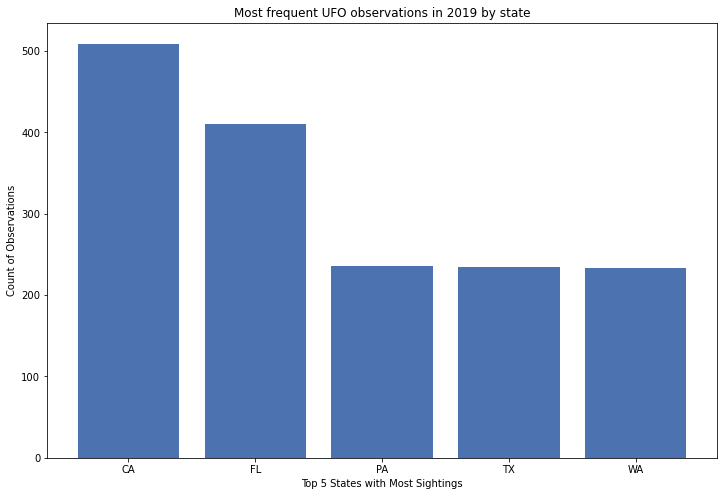

In [80]:
sns.set_palette("deep")
x = comb_final['state_abbrev_ufo'].value_counts()
x = x.reset_index()
x = x.head(5)
x1 = x['index'].to_list()
y1 = x['state_abbrev_ufo'].to_list()

plt.bar(x1,y1)
plt.title('Most frequent UFO observations in 2019 by state')
plt.xlabel("Top 5 States with Most Sightings")
plt.ylabel("Count of Observations")

## how does the number of sightings compare to the number of bases per state in 2019?

'\nWhat are the trends in sightings corresponding to military base variables?\nDo certain branches of military bases have a higher number of sightings?\nAir Force\nDo larger bases have higher numbers of sightings?\nAre certain types of UFOs commonly reported near certain types of bases?\nIe: Do air force bases tend to have more circular shaped sightings, etc… \n'

State  Number of Bases  Sightings
0                .Alabama               32         59
1                 .Alaska               15         20
2                .Arizona               19        229
3               .Arkansas                5         72
4             .California               73        509
5               .Colorado               10        130
6            .Connecticut                5        123
7               .Delaware                4         14
8   .District of Columbia                5          1
9                .Florida               41        410
10               .Georgia               20        161
11                .Hawaii               39         49
12                 .Idaho                7        104
13              .Illinois               14        163
14               .Indiana               11        182
15                  .Iowa                5         42
16                .Kansas                7         42
17              .Kentucky                6         74
18             .Louisiana               14         43
19                 .Maine                7         56
20              .Maryland               25         68
21         .Massachusetts               10        116
22              .Michigan                9        135
23             .Minnesota               10        127
24           .Mississippi               12         33
25              .Missouri               13        126
26               .Montana                5         61
27              .Nebraska                8         31
28                .Nevada               13         68
29         .New Hampshire                4         77
30            .New Jersey               10        192
31            .New Mexico               10         88
32              .New York               17        189
33        .North Carolina               16        162
34          .North Dakota                7         18
35                  .Ohio               15        209
36              .Oklahoma               15         67
37                .Oregon               11        131
38          .Pennsylvania               16        236
39          .Rhode Island                5         32
40        .South Carolina               14        115
41          .South Dakota                7         15
42             .Tennessee               15        126
43                 .Texas               42        235
44                  .Utah               11         81
45               .Vermont                5         22
46              .Virginia               42        193
47            .Washington               20        233
48         .West Virginia                8         40
49             .Wisconsin                7        136
50               .Wyoming                3         21

<AxesSubplot:title={'center':'Number of Bases and Number of Sightings per State in 2019'}, ylabel='State'>

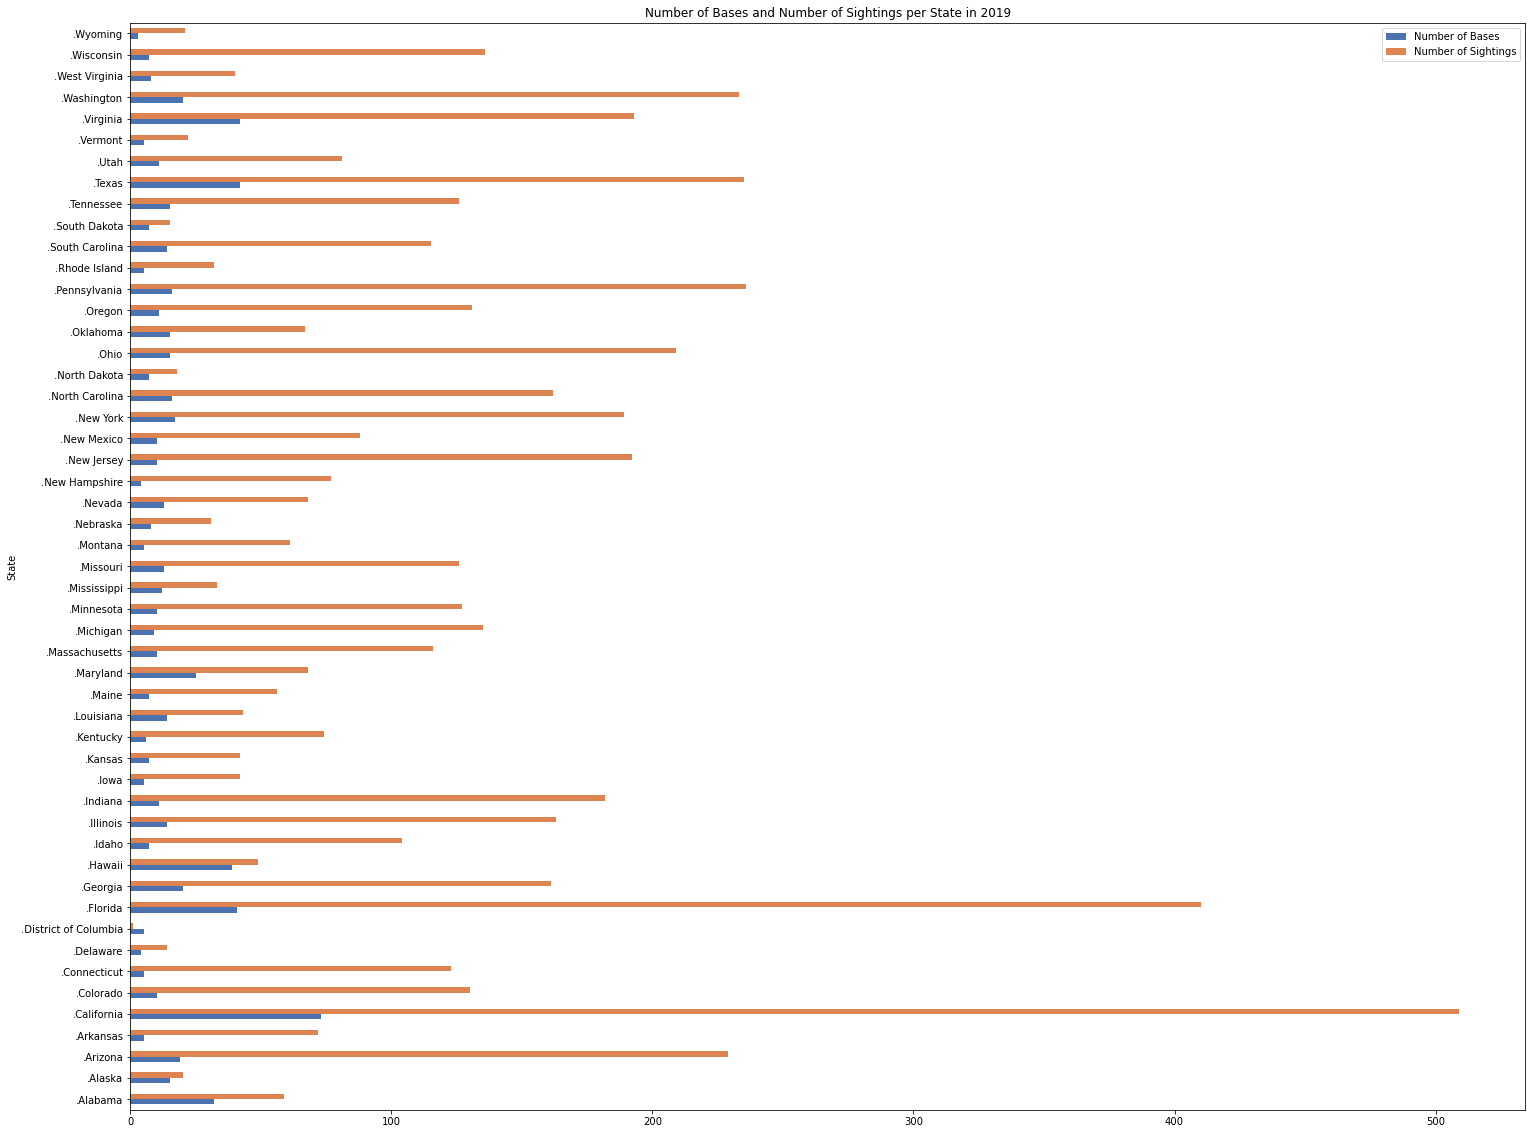

In [81]:
'''
What are the trends in sightings corresponding to military base variables?
Do certain branches of military bases have a higher number of sightings?
Air Force
Do larger bases have higher numbers of sightings?
Are certain types of UFOs commonly reported near certain types of bases?
Ie: Do air force bases tend to have more circular shaped sightings, etc… 
'''

combined_2019[['State', 'Number of Bases', 'Sightings']]

index = combined_2019.State.to_list()
blue = combined_2019['Number of Bases'].to_numpy()
orange = combined_2019['Sightings'].to_numpy()
graph_df = pd.DataFrame({'Number of Bases':blue, 'Number of Sightings':orange}, index=index)
graph_df.plot.barh(figsize=(25,20), title= 'Number of Bases and Number of Sightings per State in 2019', xlabel= 'State', ylabel='Count', logx= False)
plt.show()

<AxesSubplot:title={'center':'Number of Bases and Number of Sightings per State in 2019'}, ylabel='State'>

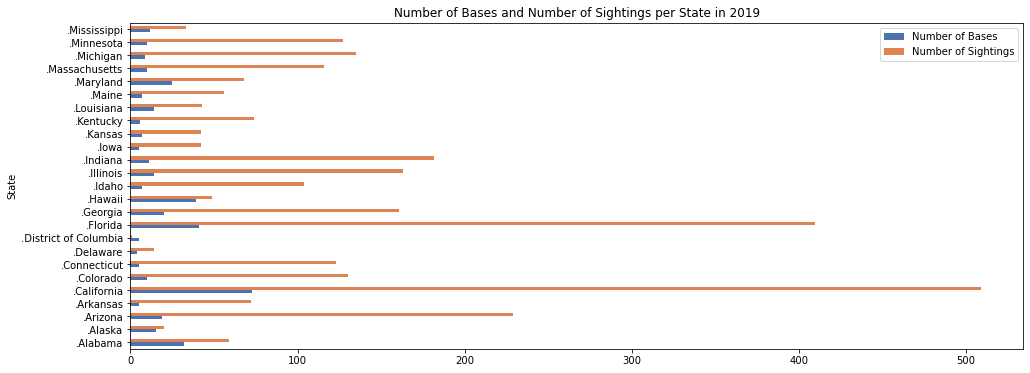

In [82]:
index = combined_2019.State.head(25).to_list()
blue = combined_2019['Number of Bases'].head(25).to_numpy()
orange = combined_2019['Sightings'].head(25).to_numpy()
graph_df = pd.DataFrame({'Number of Bases':blue, 'Number of Sightings':orange}, index=index)
graph_df.plot.barh(figsize=(16,6), title= 'Number of Bases and Number of Sightings per State in 2019', xlabel= 'State', ylabel='Count', logx= False)
plt.show()

<AxesSubplot:title={'center':'Number of Bases and Number of Sightings per State in 2019'}, ylabel='State'>

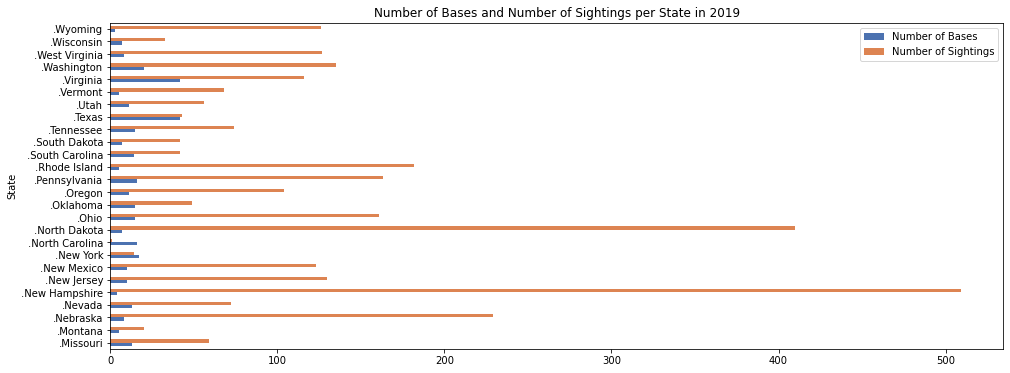

In [83]:
index = combined_2019.State.tail(26).to_list()
blue = combined_2019['Number of Bases'].tail(26).to_numpy()
orange = combined_2019['Sightings'].head(26).to_numpy()
graph_df = pd.DataFrame({'Number of Bases':blue, 'Number of Sightings':orange}, index=index)
graph_df.plot.barh(figsize=(16,6), title= 'Number of Bases and Number of Sightings per State in 2019', xlabel= 'State', ylabel='Count', logx= False)
plt.show()

In [84]:
#CA, TX, VA, FL, WA, PA
#choosing states with sightings that are > 100 & > 15 bases
#number of sightings per branch
#looking at the sights and number of bases per state to see if there is any relationship / choose states to analyze
print(combined_2019[['State', 'Number of Bases', 'Sightings']].sort_values(by='Number of Bases',ascending= False).head(15))
print(50*'-')
print(combined_2019[['State', 'Number of Bases', 'Sightings']].sort_values(by='Sightings',ascending= False).head(15))

              State  Number of Bases  Sightings
4       .California               73        509
43           .Texas               42        235
46        .Virginia               42        193
9          .Florida               41        410
11          .Hawaii               39         49
0          .Alabama               32         59
20        .Maryland               25         68
47      .Washington               20        233
10         .Georgia               20        161
2          .Arizona               19        229
32        .New York               17        189
38    .Pennsylvania               16        236
33  .North Carolina               16        162
42       .Tennessee               15        126
1           .Alaska               15         20
--------------------------------------------------
              State  Number of Bases  Sightings
4       .California               73        509
9          .Florida               41        410
38    .Pennsylvania               16 

In [85]:
#add navy
comb_final['army_count'] = comb_final['ArmyActive_Active'] + comb_final['ArmyGuard_Active'] + comb_final['ArmyReserve_Active']
comb_final['mc_count'] = comb_final['MCActive_Active'] + comb_final['MCReserve_Active']
comb_final['af_count'] = comb_final['AFActive_Active'] + comb_final['AFGuard_Active'] + comb_final['AFReserve_Active']

In [86]:
#CA, TX, VA, FL, WA, PA
#takign a looking at the values from the df that I want to graph
comb_final[['state_abbrev_ufo', 'datetime','af_count', 'mc_count', 'army_count', 'NavyActive_Active']]

state_abbrev_ufo       datetime  af_count  mc_count  army_count  \
69605               NV  1/31/19 21:00       5.0       0.0         3.0   
69606               GA  1/31/19 20:27       5.0       2.0        11.0   
69607               CA  1/31/19 20:03      13.0       9.0         9.0   
69608               OR  1/31/19 18:00       2.0       0.0         8.0   
69609               CA  1/31/19 18:00      13.0       9.0         9.0   
...                ...            ...       ...       ...         ...   
75467               NC  12/1/19 06:00       4.0       7.0         5.0   
75468               IN  12/1/19 04:48       2.0       0.0         5.0   
75469               VA  12/1/19 01:25       2.0       2.0        11.0   
75470               ME  12/1/19 00:30       1.0       0.0         4.0   
75471               AZ  12/1/19 00:06       8.0       2.0         8.0   

       NavyActive_Active  
69605                5.0  
69606                1.0  
69607               38.0  
69608                1.0  
69609               38.0  
...                  ...  
75467                0.0  
75468                1.0  
75469               25.0  
75470                2.0  
75471                1.0  

[5867 rows x 6 columns]

In [87]:
#Grouping and reorganizing to properly display data for graphing
grouped_df = comb_final.groupby('state_abbrev_ufo').agg({'datetime': 'count', 'af_count': 'first', 'mc_count': 'first', 'army_count': 'first', 'NavyActive_Active': 'first'})
grouped_df = grouped_df.rename(columns = {'datetime': 'sightings_count'})
grouped_df = grouped_df.sort_values('sightings_count', ascending= False).head(12)

grouped_df_zoom = grouped_df.sort_values('sightings_count', ascending= False).head(5)
grouped_df.head(15)

sightings_count  af_count  mc_count  army_count  \
state_abbrev_ufo                                                    
CA                            509      13.0       9.0         9.0   
FL                            410      14.0       2.0         2.0   
PA                            236       2.0       0.0        11.0   
TX                            235      17.0       0.0        14.0   
WA                            233       3.0       0.0         5.0   
AZ                            229       8.0       2.0         8.0   
OH                            209       6.0       0.0         8.0   
VA                            193       2.0       2.0        11.0   
NJ                            192       4.0       0.0         3.0   
NY                            189       7.0       2.0         7.0   
IN                            182       2.0       0.0         5.0   
IL                            163       3.0       0.0         5.0   

                  NavyActive_Active  
state_abbrev_ufo                     
CA                             38.0  
FL                             23.0  
PA                              3.0  
TX                              9.0  
WA                             12.0  
AZ                              1.0  
OH                              1.0  
VA                             25.0  
NJ                              2.0  
NY                              1.0  
IN                              1.0  
IL                              4.0

The bar graph displays each military base broken down into service, along with the reported number of UFO sightings in each state. This graph will allows us to see if there is a relationship between certain types of military bases (ex. Air Force) and the number of UFO sightings.

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

Text(0, 0.5, 'Count')

Text(0.5, 0, 'State')

([<matplotlib.axis.XTick at 0x7f92d7fdad30>,
 [Text(0, 0, 'CA'),
  Text(1, 0, 'FL'),
  Text(2, 0, 'PA'),
  Text(3, 0, 'TX'),
  Text(4, 0, 'WA'),
  Text(5, 0, 'AZ'),
  Text(6, 0, 'OH'),
  Text(7, 0, 'VA'),
  Text(8, 0, 'NJ'),
  Text(9, 0, 'NY'),
  Text(10, 0, 'IN'),
  Text(11, 0, 'IL')])

Text(0.5, 1.0, 'Relationship between Military Base Type and Sightings in 2019')

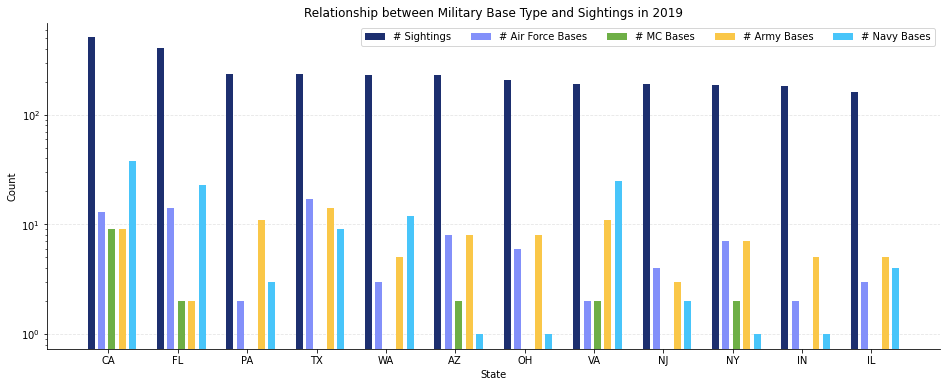

In [88]:
# define figure
fig, ax = plt.subplots(1, figsize=(16, 6))

#sets x index
x = np.arange(0, len(grouped_df.index))

# plot bars
plt.bar(x - 0.25, grouped_df['sightings_count'], width = 0.1, color = '#1D2F6F', align='center')
plt.bar(x - 0.1, grouped_df['af_count'], width = 0.1, color = '#8390FA', align='center')
plt.bar(x + 0.05, grouped_df['mc_count'], width = 0.1, color = '#6EAF46', align='center')
plt.bar(x + 0.2, grouped_df['army_count'], width = 0.1, color = '#FAC748', align='center')
plt.bar(x + 0.35, grouped_df['NavyActive_Active'], width = 0.1, color = '#48c5fa', align='center')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x axis / y axis details
plt.ylabel('Count')
plt.xlabel('State')
plt.yscale('log')
plt.xticks(x, grouped_df.index)
#plt.xlim(-0.5, 31)
#plt.ylim(0, 500)

#dashed grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.2)

# title and legend set
plt.title('Relationship between Military Base Type and Sightings in 2019', loc ='center')
plt.legend(['# Sightings', '# Air Force Bases', '# MC Bases', '# Army Bases', '# Navy Bases'], loc='upper right', ncol = 5)
plt.show()

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

Text(0, 0.5, 'Count')

Text(0.5, 0, 'State')

([<matplotlib.axis.XTick at 0x7f92d7fef670>,
 [Text(0, 0, 'CA'),
  Text(1, 0, 'FL'),
  Text(2, 0, 'PA'),
  Text(3, 0, 'TX'),
  Text(4, 0, 'WA')])

Text(0.5, 1.0, 'Relationship between Military Base Type and Sightings in 2019')

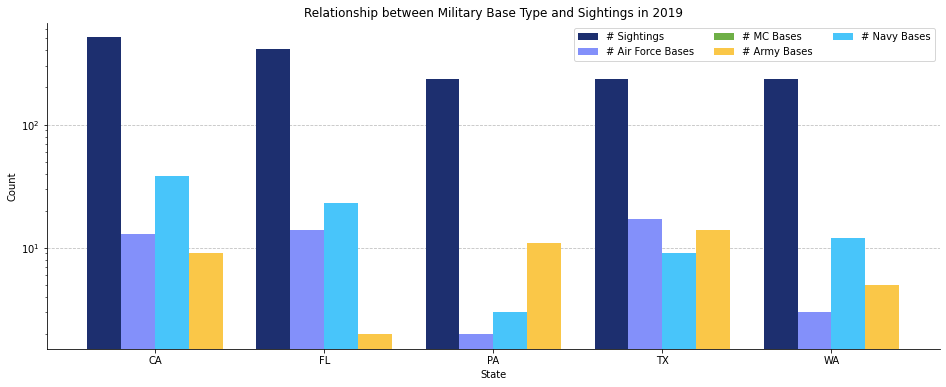

In [89]:
# define figure
fig, ax = plt.subplots(1, figsize=(16, 6))

# numerical x
x = np.arange(0, len(grouped_df_zoom.index))

# plot bars
plt.bar(x - 0.3, grouped_df_zoom['sightings_count'], width = 0.2, color = '#1D2F6F')
plt.bar(x - 0.1, grouped_df_zoom['af_count'], width = 0.2, color = '#8390FA')
plt.bar(x + 0.1, grouped_df_zoom['mc_count'], width = 0.2, color = '#6EAF46')
plt.bar(x + 0.3, grouped_df_zoom['army_count'], width = 0.2, color = '#FAC748')
plt.bar(x + 0.1, grouped_df_zoom['NavyActive_Active'], width = 0.2, color = '#48c5fa')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x y details
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('State')
plt.xticks(x, grouped_df_zoom.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.5)

# title and legend
plt.title('Relationship between Military Base Type and Sightings in 2019', loc ='center')
plt.legend(['# Sightings', '# Air Force Bases', '# MC Bases', '# Army Bases', '# Navy Bases'], loc='upper right', ncol = 3)
plt.show()